# 1. 불러오기

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1 라이브러리 불러오기

In [10]:
import sys
sys.path.append('src')
import enex_analysis as enex
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dartwork_mpl as dm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib import cm
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec
dm.use_style()

## 1.2 파일 불러오기

In [11]:
# small office 데이터 파일 불러오기
file_path = 'data/'
small_office_df = pd.read_csv(file_path + 'small_office_hour.csv')
# small_office_df = pd.read_csv(file_path + 'dual_setpoint_smalloffice.csv')

# 데이터프레임의 컬럼 이름 프린트
print(small_office_df.columns)

Index(['Date/Time',
       'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)',
       'ATTIC:Zone Air Temperature [C](TimeStep)',
       'CORE_ZN:Zone Air Temperature [C](TimeStep)',
       'PERIMETER_ZN_1:Zone Air Temperature [C](TimeStep)',
       'PERIMETER_ZN_2:Zone Air Temperature [C](TimeStep)',
       'PERIMETER_ZN_3:Zone Air Temperature [C](TimeStep)',
       'PERIMETER_ZN_4:Zone Air Temperature [C](TimeStep)',
       'ATTIC IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)',
       'ATTIC IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Total Cooling Energy [J](TimeStep)',
       'CORE_ZN IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)',
       'CORE_ZN IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Total Cooling Energy [J](TimeStep)',
       'PERIMETER_ZN_1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)',
       'PERIMETER_ZN_1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone To

## 1.3 주말 부하 = 0 으로 설정 + 10-3월은 난방만, 4-9월은 냉방만 발생

In [12]:
# 1. Date/Time 열 공백 정리
weekday_df = small_office_df.copy()
weekday_df['Date/Time_clean'] = weekday_df['Date/Time'].str.strip().str.replace(r'\s+', ' ', regex=True)

# 2. 시간 인덱스 기반으로 '요일' 계산 (1월 1일 = 일요일)
weekday_df['Relative_Day_Index'] = weekday_df.index // 24
weekday_df['Day'] = (6 + weekday_df['Relative_Day_Index']) % 7 

# 3. 평일 데이터만 필터링 (Weekday 0~4 → 월~금)
weekday_df.loc[weekday_df['Day'].isin([5, 6]), 'DistrictCooling:Facility [J](TimeStep)'] = 0
weekday_df.loc[weekday_df['Day'].isin([5, 6]), 'DistrictHeatingWater:Facility [J](TimeStep) '] = 0
# weekday_df.loc[weekday_df['Day'].isin([5, 6]), 'DistrictCooling:Facility [J](TimeStep) '] = 0
# weekday_df.loc[weekday_df['Day'].isin([5, 6]), 'DistrictHeating:Facility [J](TimeStep)'] = 0

# 4. 10-3월은 난방만, 4-9월은 냉방만 발생하도록 설정
# 월 정보 추출
weekday_df['Month'] = weekday_df['Date/Time_clean'].str.slice(0, 2).astype(int)
# 난방월에는 냉방 부하를 0으로 설정
weekday_df.loc[weekday_df['Month'].isin([1, 2, 3, 10, 11, 12]), 'DistrictCooling:Facility [J](TimeStep)'] = 0
# 냉방월에는 난방 부하를 0으로 설정
weekday_df.loc[weekday_df['Month'].isin([4, 5, 6, 7, 8, 9]), 'DistrictHeatingWater:Facility [J](TimeStep) '] = 0

# 4. 필요시 인덱스 초기화
weekday_df.reset_index(drop=True, inplace=True)

## 1.4 환경온도, 실내온도, 부하 리스트 생성

In [13]:
# 변수(환경온도, 실내온도, 부하) 리스트 생성
date_list = weekday_df['Date/Time_clean'] # 날짜
Toa_list = weekday_df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'] # 환경온도
Tia_list = weekday_df['CORE_ZN:Zone Air Temperature [C](TimeStep)'] # 실내온도
cooling_load_list = weekday_df['DistrictCooling:Facility [J](TimeStep)'] / 3600 # 냉방부하, J -> W
heating_load_list = weekday_df['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600 # 난방부하, J -> W
# cooling_load_list = weekday_df['DistrictCooling:Facility [J](TimeStep) '] / 3600 # 냉방부하, J -> W
# heating_load_list = weekday_df['DistrictHeating:Facility [J](TimeStep)'] / 3600 # 난방부하, J -> W
ATTIC_ZT = weekday_df['ATTIC:Zone Air Temperature [C](TimeStep)'] # 옥상 온도
CORE_ZT = weekday_df['CORE_ZN:Zone Air Temperature [C](TimeStep)'] # 실내 온도
PERIMETER_Z1T = weekday_df['PERIMETER_ZN_1:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z2T = weekday_df['PERIMETER_ZN_2:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z3T = weekday_df['PERIMETER_ZN_3:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z4T = weekday_df['PERIMETER_ZN_4:Zone Air Temperature [C](TimeStep)'] # 주변 온도
Date = weekday_df['Date/Time'] # 날짜

Zone_temp_list = [CORE_ZT, PERIMETER_Z1T, PERIMETER_Z2T, PERIMETER_Z3T, PERIMETER_Z4T]

# 리스트 길이 확인
len(date_list), len(Toa_list), len(Tia_list), len(cooling_load_list), len(heating_load_list), len(Date)

(8760, 8760, 8760, 8760, 8760, 8760)

## 1.5 COP, 엑서지 효율 리스트 생성

In [14]:
round(max(cooling_load_list), 0), round(max(heating_load_list), 0)

(23747.0, 27408.0)

## 1.6 Fontsize

In [15]:
## Fontsize 지정
plt.rcParams['font.size'] = 9

fs = {
    'label': dm.fs(0),
    'tick': dm.fs(-1.5),
    'legend': dm.fs(-2.0),
    'subtitle': dm.fs(-0.5),
    'cbar_tick': dm.fs(-2.0),
    'cbar_label': dm.fs(-1.0),
    'cbar_title': dm.fs(-1),
    'setpoint': dm.fs(-1),
    'text': dm.fs(-3.0),
            }

pad = {
    'label': 6,
    'tick': 5,
}

LW = np.arange(0.25, 3.0, 0.25)

# 2. 엑서지 효율 분석

## 2.1 엑서지 효율 계산 및 리스트 생성

In [40]:
# 부하가 음수인 경우 확인
print("Cooling load < 0: ", len([x for x in cooling_load_list if x < 0]))
print("Heating load < 0: ", len([x for x in heating_load_list if x < 0]))

Cooling load < 0:  0
Heating load < 0:  0


In [41]:
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []
ASHP_cooling_COP = []
ASHP_heating_COP = []
dV_int_cooling_list = []
dV_ext_cooling_list = []
dV_int_heating_list = []
dV_ext_heating_list = []

for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_room = 22
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        if ASHP_cooling.X_eff < 0:
            ASHP_cooling_exergy_effi.append(None)
            ASHP_cooling_COP.append(None)
        else:          
            ASHP_cooling_exergy_effi.append(ASHP_cooling.X_eff)
            ASHP_cooling_COP.append(ASHP_cooling.COP_sys)
            dV_int_cooling_list.append(ASHP_cooling.dV_int)
            dV_ext_cooling_list.append(ASHP_cooling.dV_ext)
    else:
        ASHP_cooling_exergy_effi.append(None)
        ASHP_cooling_COP.append(None)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_room = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update() 
        if ASHP_heating.X_eff < 0:
            ASHP_heating_exergy_effi.append(None)
            ASHP_heating_COP.append(None)
        else:
            ASHP_heating_exergy_effi.append(ASHP_heating.X_eff)
            ASHP_heating_COP.append(ASHP_heating.COP_sys)
            dV_int_heating_list.append(ASHP_heating.dV_int)
            dV_ext_heating_list.append(ASHP_heating.dV_ext)
    else:
        ASHP_heating_exergy_effi.append(None)
        ASHP_heating_COP.append(None)

# COP None 값일 때 해당하는 COP를 제거한 필터링된 리스트
ASHP_cooling_COP_filtered = [cop for cop in ASHP_cooling_COP if cop is not None]
ASHP_heating_COP_filtered = [cop for cop in ASHP_heating_COP if cop is not None]
ASHP_cooling_exergy_effi_filtered = [eff for eff in ASHP_cooling_exergy_effi if eff is not None]
ASHP_heating_exergy_effi_filtered = [eff for eff in ASHP_heating_exergy_effi if eff is not None]

# 엑서지효율 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Date_cooling_list_filtered = [date for date, eff in zip(date_list, ASHP_cooling_exergy_effi) if eff is not None]
Date_heating_list_filtered = [date for date, eff in zip(date_list, ASHP_heating_exergy_effi) if eff is not None]
Tia_cooling_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_cooling_exergy_effi) if eff is not None]
Tia_heating_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_heating_exergy_effi) if eff is not None]
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]

len(ASHP_cooling_COP_filtered), len(ASHP_heating_COP_filtered), len(Date_cooling_list_filtered), len(Date_heating_list_filtered), len(Tia_cooling_list_filtered), len(Tia_heating_list_filtered), len(Toa_cooling_list_filtered), len(Toa_heating_list_filtered), len(cooling_load_list_filtered), len(heating_load_list_filtered)

(1693, 1701, 1693, 1701, 1693, 1701, 1693, 1701, 1693, 1701)

# 2. 엑서지 효율 분석

## 2.1 엑서지 효율 그래프

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.45, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.55, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(17), dm.cm2in(8)))
plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Fontsize
label_fontsize = dm.fs(1.0)
tick_fontsize = dm.fs(0)
cbar_fontsize = dm.fs(-0.8)
cbar_title_fontsize = dm.fs(-0.8)
setpoint_fontsize = dm.fs(-0.5)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=0, vmax=24)
norm_heating = mcolors.Normalize(vmin=0, vmax=32)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 1000 for load in cooling_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_cooling_exergy_effi_filtered],
                 cmap=coolwarm_left.reversed(), 
                 s=2.5, alpha=1.0, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
cbar1.set_ticks(np.arange(0, 25, 6))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 1000 for load in heating_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_heating_exergy_effi_filtered], 
                 cmap=coolwarm_right, 
                 s=2.5, alpha=1.0, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_ticks(np.arange(0, 33, 8))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad+2)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 23, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 30)

# label
ax.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.linspace(0, 30, 7))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

plt.savefig('figure/exergy_efficiency_one_graph_divide_mode.png', dpi=600)
dm.util.save_and_show(fig)

## 2.2 엑서지 효율 카운트

In [ ]:
# 엑서지 효율 데이터 필터링
filtered_cooling_exergy_efficiency = [eff * 100 for eff in ASHP_cooling_exergy_effi_filtered if 0 <= eff * 100 <= 40]
filtered_heating_exergy_efficiency = [eff * 100 for eff in ASHP_heating_exergy_effi_filtered if 0 <= eff * 100 <= 40]

bins1 = np.arange(0, 41, 1)
bins2 = np.arange(0, 41, 1)

# set up the plot
fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(17), dm.cm2in(7)), sharey=None)
plt.subplots_adjust(left=0.07, right=0.97, top=0.9, bottom=0.15, wspace=0.15, hspace=0.4)

# histogram plot
axes[0].hist(filtered_cooling_exergy_efficiency, bins=bins1, alpha=0.5, color='#5787D7', edgecolor='#3B4CC0') 
axes[1].hist(filtered_heating_exergy_efficiency, bins=bins2, alpha=0.5, color='#E87B68', edgecolor='#C6413D') 

# Common setting
label_pad = 7
line_width = 0.4

# Limit
axes[0].set_xlim(-2, 42)
axes[0].set_ylim(0, 250)
axes[1].set_xlim(-2, 42)
axes[1].set_ylim(0, 250)

# Label
axes[0].set_xlabel('Exergy Efficiency [%]', fontsize=label_fontsize, labelpad=label_pad)
axes[0].set_ylabel('Count', fontsize=label_fontsize, labelpad=label_pad)
axes[1].set_xlabel('Exergy Efficiency [%]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
axes[0].set_xticks(np.arange(0, 42, 5))
axes[0].set_yticks(np.arange(0, 251, 50))
axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)
axes[1].set_xticks(np.arange(0, 42, 5))
axes[1].set_yticks(np.arange(0, 251, 50)) 
axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

# Grid
axes[0].grid(True, which='major', linestyle='--', linewidth=0.1, alpha=0.7)
axes[1].grid(True, which='major', linestyle='--', linewidth=0.1, alpha=0.7)

# subtitle
axes[0].text(0.01, 1.09, '(a) Cooling mode', transform=axes[0].transAxes, fontsize=title_fontsize, va='top', ha='left')
axes[1].text(0.01, 1.09, '(b) Heating mode', transform=axes[1].transAxes, fontsize=title_fontsize, va='top', ha='left')

# plt.savefig('figure/exergy_efficiency_count.png', dpi=600)
dm.util.save_and_show(fig)

# 3. COP according to PLR

## 3.1 COP 모델 생성

In [ ]:
# parameter
T_ev_l = 12
COP_ref = 4.0

# 2d grid for cooling
PLR_cooling = np.linspace(0.0, 1.0, 500)
T_cond_e_cooling = np.linspace(15, 40, 500)
PLR_grid_cooling, T_cond_e_grid_cooling = np.meshgrid(PLR_cooling, T_cond_e_cooling)

# calculate COP for cooling
EIRFTemp_cooling = 0.38 + 0.02 * T_ev_l + 0 * T_ev_l**2 + 0.01 * T_cond_e_grid_cooling + 0 * T_cond_e_grid_cooling**2 + 0 * T_ev_l * T_cond_e_grid_cooling
EIRFPLR_cooling = 0.22 + 0.50 * PLR_grid_cooling + 0.26 * PLR_grid_cooling**2
COP_cooling = PLR_grid_cooling * COP_ref / (EIRFTemp_cooling * EIRFPLR_cooling)

# 2d grid for heating
PLR_heating = np.linspace(0.0, 1.0, 500)
T_0_heating = np.linspace(-15, 25, 500)
PLR_grid_heating, T_0_grid_heating = np.meshgrid(PLR_heating, T_0_heating)

# calculate COP for heating
COP_heating = -7.46 * (PLR_grid_heating - 0.0047 * T_0_grid_heating - 0.477) ** 2 + 0.0941 * T_0_grid_heating + 4.34

## 3.2 COP 논문 그래프

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.5, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.5, 1.0, 256))
)

# Set up the figure and axes
fig, (ax_cooling, ax_heating) = plt.subplots(1, 2, figsize=(dm.cm2in(17), dm.cm2in(7)))
plt.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.18, wspace=0.25)

# Fontsize
label_fontsize = dm.fs(1.0)
tick_fontsize = dm.fs(0)
subtitle_fontsize = dm.fs(0)
cbar_fontsize = dm.fs(-0.8)

# color
contour_cooling_color = 'dm.white'
contour_heating_color = 'dm.white'

# Common setting
label_pad = 6
tick_pad = 5

# normalize for colorbar
norm_COP_cooling = mcolors.Normalize(vmin=0, vmax=6)
norm_COP_heating = mcolors.Normalize(vmin=0, vmax=7)

# Cooling colormap
colormap_cooling = ax_cooling.pcolormesh(T_cond_e_grid_cooling, PLR_grid_cooling, COP_cooling,
                                         shading='auto',
                                         cmap=coolwarm_left.reversed(),
                                         norm=norm_COP_cooling,
                                         rasterized=True)
cbar_cooling = fig.colorbar(colormap_cooling, ax=ax_cooling)
cbar_cooling.set_label('COP [-]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar_cooling.ax.tick_params(labelsize=cbar_fontsize)
cbar_cooling.set_ticks(np.arange(0, 7, 1))

# Cooling contour lines
contour_lines_cooling = ax_cooling.contour(T_cond_e_grid_cooling, PLR_grid_cooling, COP_cooling,
                                         levels=np.arange(0.0, 6.0, 1.0), 
                                         colors=contour_cooling_color,
                                         linewidths=0.8,
                                         alpha=0.9)
ax_cooling.clabel(contour_lines_cooling, 
                  inline=True, 
                  fontsize=tick_fontsize-1, 
                  fmt='%.1f')

# Cooling graph
ax_cooling.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax_cooling.set_ylabel('Part load ratio [-]', fontsize=label_fontsize, labelpad=label_pad)
ax_cooling.set_xlim(15, 35)
ax_cooling.set_ylim(0.18, 1.0)
ax_cooling.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax_cooling.tick_params(axis='both', which='minor', labelsize=tick_fontsize, pad=tick_pad)
ax_cooling.set_xticks(np.arange(15, 36, 5))
ax_cooling.set_yticks(np.arange(0.0, 1.1, 0.2))
ax_cooling.text(0.02, 1.09, '(a) Cooling mode', transform=ax_cooling.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')

# Heating colormap
colormap_heating = ax_heating.pcolormesh(T_0_grid_heating, PLR_grid_heating, COP_heating,
                                         shading='auto',
                                         cmap=coolwarm_right,
                                         norm=norm_COP_heating,
                                         rasterized=True)
cbar_heating = fig.colorbar(colormap_heating, ax=ax_heating)
cbar_heating.set_label('COP [-]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar_heating.ax.tick_params(labelsize=cbar_fontsize)
cbar_heating.set_ticks(np.arange(0, 8, 1))

# Heating contour lines
contour_lines_heating = ax_heating.contour(T_0_grid_heating, PLR_grid_heating, COP_heating,
                                         levels=np.arange(0.0, 7.0, 1.0),
                                         colors=contour_heating_color,
                                         linewidths=0.8,
                                         alpha=0.9)
ax_heating.clabel(contour_lines_heating, 
                 inline=True, 
                 fontsize=tick_fontsize-1, 
                 fmt='%.1f')

# Heating graph
ax_heating.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax_heating.set_ylabel('Part load ratio [-]', fontsize=label_fontsize, labelpad=label_pad)
ax_heating.set_xlim(-10, 25)
ax_heating.set_ylim(0.18, 1.0)
ax_heating.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax_heating.tick_params(axis='both', which='minor', labelsize=tick_fontsize, pad=tick_pad)
ax_heating.set_xticks(np.arange(-15, 26, 10))
ax_heating.set_yticks(np.arange(0.0, 1.1, 0.2))
ax_heating.text(0.02, 1.09, '(b) Heating mode', transform=ax_heating.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')


# # Save and show the figure
plt.savefig('figure/COP_colormap_cooling_heating.png', dpi=600)
plt.savefig('figure/COP_colormap_cooling_heating.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)

## 3.3 COP 3차원 그래프

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.5, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.5, 1.0, 256))
)

# calculate temperature difference (Delta T) for heating
Delta_T_grid_heating = T_0_grid_heating - 22

# font size
label_fontsize = dm.fs(-0.5)
tick_fontsize = dm.fs(-1)
subtitle_fontsize = dm.fs(0)

# common setting
label_pad = -9
tick_pad = -5
subtitle_pad = -30

# set the plot
fig = plt.figure(figsize=(dm.cm2in(17), dm.cm2in(7)))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1)

# cooling subplot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(T_cond_e_grid_cooling - 22, PLR_grid_cooling, COP_cooling, cmap=coolwarm_left.reversed(), edgecolor='none', alpha=0.8)
ax1.set_xlabel('Temperature difference [°C]', fontsize=label_fontsize, labelpad=label_pad)
ax1.set_ylabel('Part load ratio [-]', fontsize=label_fontsize, labelpad=label_pad)
ax1.set_zlabel('COP [-]', fontsize=label_fontsize, labelpad=label_pad)
ax1.set_xlim(-4, 15)
ax1.set_ylim(0.1, 1.1)
ax1.set_zlim(1.8, 6)
ax1.set_xticks(np.arange(-4, 15, 3))
ax1.set_yticks(np.arange(0.0, 1.1, 0.2))
ax1.set_zticks(np.arange(2, 6.1, 1.0))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax1.minorticks_off()
ax1.view_init(elev=25, azim=-40)
ax1.text2D(0.05, 0.98, '(a) Cooling mode', transform=ax1.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')

# heating subplot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(Delta_T_grid_heating, PLR_grid_heating, COP_heating, cmap=coolwarm_right, edgecolor='none', alpha=0.8)
ax2.set_xlabel('Temperature difference [°C]', fontsize=label_fontsize, labelpad=label_pad)
ax2.set_ylabel('Part load ratio [-]', fontsize=label_fontsize, labelpad=label_pad)
ax2.set_zlabel('COP [-]', fontsize=label_fontsize, labelpad=label_pad)
ax2.set_xlim(-29, 3)
ax2.set_ylim(1.1, 0.1)
ax2.set_zlim(1, 7)
ax2.set_xticks(np.arange(-27, 4, 5))
ax2.set_yticks(np.arange(0.0, 1.1, 0.2))
ax2.set_zticks(np.arange(1, 7.1, 1.0))
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax2.minorticks_off()
ax2.view_init(elev=25, azim=140)
ax2.text2D(0.05, 0.98, '(b) Heating mode', transform=ax2.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')

# save and show
plt.savefig('figure/COP_surface_cooling_heating.png', dpi=600)
dm.util.save_and_show(fig)


# 4. 월별 엑서지 인풋, 소비, 아웃풋 분석

## 4.1 월별 엑서지 인풋, 소비, 아웃풋 리스트 생성

In [ ]:
# 월별 데이터를 그룹화하기 위해 'Month' 열 생성
weekday_df['Month'] = weekday_df['Date/Time_clean'].str.split('/').str[0].astype(int)

# 월별 그룹화
grouped = weekday_df.groupby('Month')

# 월별 리스트 생성
monthly_exergy_input = []
monthly_exergy_consumption = []
monthly_exergy_output = []
monthly_avg_COP = []
monthly_exergy_efficiency = []

# 월별 온도 리스트 생성
monthly_avg_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].mean().tolist()
monthly_min_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].min().tolist()
monthly_max_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].max().tolist()

for month, group in grouped:
    input_exergy = 0
    consumption_exergy = 0
    output_exergy = 0
    
    total_cooling_exergy_efficiency = 0
    total_heating_exergy_efficiency = 0
    total_cooling_COP = 0
    total_heating_COP = 0
    cooling_count = 0
    heating_count = 0

    for _, row in group.iterrows():
        Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
        Tia = row['CORE_ZN:Zone Air Temperature [C](TimeStep)']
        cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] / 3600
        heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600

        if cooling_load > 0:
            ASHP_cooling = enex.AirSourceHeatPump_cooling()
            ASHP_cooling.T0 = Toa
            ASHP_cooling.T_a_room = 22
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.Q_r_max = max(cooling_load_list)
            ASHP_cooling.system_update()
            input_exergy += (ASHP_cooling.E_cmp + ASHP_cooling.E_fan_int + ASHP_cooling.E_fan_ext) * 3600
            output_exergy += (ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in) * 3600
            total_cooling_COP += ASHP_cooling.COP
            total_cooling_exergy_efficiency += ASHP_cooling.X_eff
            cooling_count += 1
            
        if heating_load > 0:
            ASHP_heating = enex.AirSourceHeatPump_heating()
            ASHP_heating.T0 = Toa
            ASHP_heating.T_a_room = 22
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.Q_r_max = max(heating_load_list)
            ASHP_heating.system_update()
            input_exergy += (ASHP_heating.E_cmp + ASHP_heating.E_fan_int + ASHP_heating.E_fan_ext) * 3600
            output_exergy += (ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in) * 3600
            total_heating_COP += ASHP_heating.COP
            total_heating_exergy_efficiency += ASHP_heating.X_eff
            heating_count += 1

    consumption_exergy = input_exergy - output_exergy

    monthly_exergy_input.append(input_exergy / 1000000000)
    monthly_exergy_consumption.append(consumption_exergy / 1000000000)
    monthly_exergy_output.append(output_exergy / 1000000000)

    avg_exergy_efficiency = (total_cooling_exergy_efficiency + total_heating_exergy_efficiency) / (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None
    monthly_exergy_efficiency.append(avg_exergy_efficiency * 100 if avg_exergy_efficiency is not None else 0)
    avg_COP = (total_cooling_COP + total_heating_COP) / (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None
    monthly_avg_COP.append(avg_COP)



## 4.2 월별 환경온도, COP, 엑서지 효율 그래프

In [ ]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.08, right=0.83, top=0.95, bottom=0.1)

# Fontsize
label_fontsize = dm.fs(-0.5)
tick_fontsize = dm.fs(-0.5)
legend_fontsize = dm.fs(-1.0)

# Common settings
label_pad = 5
line_width = 0.8
marker_size = 1.2

# Colors
color_temp = 'dm.blue7'
color_cop = 'dm.green7'
color_efficiency = 'dm.red7'
color_22C = 'dm.blue3'

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for spine in ax1.spines.values():
    spine.set_visible(False)

# Plot environmental temperature on the left y-axis
ax1.plot(labels, monthly_avg_temp, color=color_temp, label='Environmental temperature [°C]', marker='o', markersize=marker_size, linewidth=line_width, zorder=1)
ax1.set_ylabel('Environmental temperature [°C]', fontsize=label_fontsize, labelpad=label_pad, color=color_temp)
ax1.tick_params(axis='y', which='both', labelsize=tick_fontsize, colors=color_temp)
ax1.set_ylim(0, 30)
ax1.set_yticks(np.arange(0, 31, 5))
ax1.spines['left'].set_visible(True)
ax1.spines['left'].set_color(color_temp)

# 22°C
ax1.axhline(y=22, color=color_22C, linestyle='--', linewidth=line_width, zorder=0)

# Create the first right y-axis for COP
ax2 = ax1.twinx()
for spine in ax2.spines.values():
    spine.set_visible(False)
    
ax2.plot(labels, monthly_avg_COP, color=color_cop, label='COP [-]', marker='o', markersize=marker_size, linewidth=line_width, zorder=1)
ax2.set_ylabel('COP [-]', fontsize=label_fontsize, labelpad=label_pad, color=color_cop)
ax2.tick_params(axis='y', which='both', labelsize=tick_fontsize, colors=color_cop)
ax2.set_ylim(1.5, 4.5)
ax2.set_yticks(np.arange(1.5, 4.6, 0.5))
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(color_cop)

# Create the second right y-axis for exergy efficiency
ax3 = ax1.twinx()
for spine in ax3.spines.values():
    spine.set_visible(False)
    
ax3.spines['right'].set_position(('outward', 38))
ax3.plot(labels, monthly_exergy_efficiency, color=color_efficiency, label='Exergy efficiency [%]', marker='o', markersize=marker_size, linewidth=line_width, zorder=1)
ax3.set_ylabel('Exergy efficiency [%]', fontsize=label_fontsize, labelpad=label_pad, color=color_efficiency)
ax3.tick_params(axis='y', which='both', labelsize=tick_fontsize, colors=color_efficiency)
ax3.set_ylim(0, 30)
ax3.set_yticks(np.arange(0, 31, 5))
ax3.spines['right'].set_visible(True)
ax3.spines['right'].set_color(color_efficiency)

# x-axis label
ax1.spines['bottom'].set_visible(True)
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, fontsize=tick_fontsize)
ax1.tick_params(axis='x', which='minor', bottom=False)

# Grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Legends
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
ax1.legend(lines, labels, 
           loc='lower right', 
           fontsize=legend_fontsize, 
           columnspacing=0.8, labelspacing=0.5,
           bbox_to_anchor=(0.89, 0.01),
           handlelength=1.8,
           frameon=False)

# Save and show
plt.savefig('figure/monthly_temp_cop_efficiency.png', dpi=600)
dm.util.save_and_show(fig)

## 4.3 월별 엑서지 환경온도 + 인풋, 소비, 아웃풋 그래프

In [ ]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(1, 13)

# Create figure with 2 subplots vertically stacked
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(dm.cm2in(17), dm.cm2in(11)), gridspec_kw={'height_ratios': [1.0, 1.4]})
plt.subplots_adjust(left=0.08, right=0.97, top=0.95, bottom=0.08, wspace=0.2, hspace=0.2)

# Fontsize
label_fontsize = dm.fs(1.0)
tick_fontsize = dm.fs(0)
legend_fontsize = dm.fs(-1.0)
text_fontsize = dm.fs(-1.5)
setpoint_fontsize = dm.fs(-0.5)
subtitle_fontsize = dm.fs(-1.0)

# Colors
fill_color = 'dm.gray1'
min_temp_color = 'dm.blue5'
max_temp_color = 'dm.red5'
avg_temp_color = 'dm.gray8'
percentage_color = 'dm.black'

# Common setting
marker_size = 3
line_width = 0.5
label_pad = 7

# --- FIRST SUBPLOT: TEMPERATURE ---
ax1.fill_between(x, monthly_min_temp, monthly_max_temp, color=fill_color, alpha=0.6)

# Line plot
ax1.plot(x, monthly_max_temp, color=max_temp_color, linewidth=line_width, label='Max')
ax1.plot(x, monthly_avg_temp, color=avg_temp_color, linewidth=line_width, label='Avg')
ax1.plot(x, monthly_min_temp, color=min_temp_color, linewidth=line_width, label='Min')

# Dot plot
ax1.scatter(x, monthly_min_temp, color=min_temp_color, s=marker_size, zorder=3)
ax1.scatter(x, monthly_max_temp, color=max_temp_color, s=marker_size, zorder=3)
ax1.scatter(x, monthly_avg_temp, color=avg_temp_color, s=marker_size, zorder=3)

# Limit
ax1.set_xlim(0.5, 12.5)
ax1.set_ylim(-10, 40)

# Tick
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=tick_fontsize)
ax1.set_yticks(np.arange(-10, 41, 10))
ax1.set_yticklabels(np.arange(-10, 41, 10), fontsize=tick_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', which='minor', bottom=False)
ax2.text(0.01, 0.97, '(a)', transform=ax1.transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')

# Axis and title
ax1.set_ylabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(
    loc='upper right', ncol=3, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

ax1.axhline(y=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax1.text(0.6, 24, 'Setpoint temperature', rotation=0, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# --- SECOND SUBPLOT: EXERGY STACKED BAR ---
# Exergy input
total_exergy = np.array(monthly_exergy_input)

# Common settings
bar_width = 0.57

# Colors
colors = ['dm.gray2', 'dm.green3']
edge_color = 'dm.gray8'

# Stacked bar plot
bar_top = ax2.bar(x, monthly_exergy_consumption, bar_width, bottom=monthly_exergy_output, 
                 label='Exergy consumption', color=colors[0], alpha=1.0, zorder=3)
bar_bottom = ax2.bar(x, monthly_exergy_output, bar_width, 
                    label='Exergy output', color=colors[1], alpha=0.75, zorder=3)

# Add percentage labels
for i in range(len(labels)):
    x_pos = x[i]
    consumption = monthly_exergy_consumption[i]
    output = monthly_exergy_output[i]
    consumption_ratio = consumption * 100 / total_exergy[i]
    output_ratio = output * 100 / total_exergy[i]
    ax2.text(
        x_pos, output + consumption / 2,
        f'{consumption_ratio:.1f}%',
        ha='center', va='center',
        fontsize=text_fontsize, color=percentage_color, zorder=4)
    ax2.text(
        x_pos, output / 2,
        f'{output_ratio:.1f}%',
        ha='center', va='center',
        fontsize=text_fontsize, color=percentage_color, zorder=4)
    
# Add rectangle outlines
for i in range(len(labels)):
    total_height = monthly_exergy_consumption[i] + monthly_exergy_output[i]
    rect = plt.Rectangle(
        (x[i] - bar_width / 2, 0),
        bar_width,
        total_height,
        linewidth=line_width,
        edgecolor=edge_color,
        facecolor='none',
        alpha=0.7, zorder=3
    )
    ax2.add_patch(rect)

# Create custom legend element
from matplotlib.patches import Patch
input_legend = Patch(
    facecolor='none', edgecolor=edge_color,
    linewidth=line_width, alpha=0.7,
    label='Exergy input'
)

# Label
ax2.set_ylabel('Exergy [GWh]', fontsize=label_fontsize, labelpad=label_pad+5)

# Limit
ax2.set_xlim(0.5, 12.5)
ax2.set_ylim(0, 5)

# Tick
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=tick_fontsize)
ax2.set_yticks(np.arange(0, 6, 1))
ax2.set_yticklabels(np.arange(0, 6, 1), fontsize=tick_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.tick_params(axis='x', which='major', bottom=False)
ax2.tick_params(axis='x', which='minor', bottom=False)
ax2.text(0.01, 0.97, '(b)', transform=ax2.transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')


# Grid
ax2.grid(True, linestyle='--', alpha=0.6, zorder=1)
ax2.xaxis.grid(False)

# Legend
handles, labels_ = ax2.get_legend_handles_labels()
handles.insert(0, input_legend)
labels_.insert(0, 'Exergy input')
ax2.legend(
    handles, labels_,
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.99, 0.99),
    handlelength=1.8
)

plt.savefig('figure/montyly_temp_bar.png', dpi=600)
plt.savefig('figure/montyly_temp_bar.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)

## 4.4 환경온도별 실외기 Net exergy 엑서지 

In [ ]:
# fs
label_fs = dm.fs(0.8)
tick_fs = dm.fs(0)
legend_fs = dm.fs(-0.5)
subtitle_fs = dm.fs(0.5)
cbar_fs = dm.fs(-0.8)
cbar_title_fs = dm.fs(-0.8)
setpoint_fs = dm.fs(-0.5)
text_fs = dm.fs(-1.5)

In [ ]:
xmin, xmax, xint, xmar = -20, 50, 10, 0
ymin, ymax, yint, ymar =  0, 8, 2, 0

# constant
c_a = 1005 # Specific heat capacity of air [J/kgK]
rho_a = 1.225 # Density of air [kg/m³]
k_a = 0.0257 # Thermal conductivity of air [W/mK]


T_range = np.arange(xmin, xmax+xint, 0.1)
T_a_int_in = 22

T0_cooling = -6
T0_heating = 33
T0 = np.array([T0_cooling, T0_heating])

T_range_K = enex.C2K(T_range)
T0_K = enex.C2K(T0)


dV_int_unit = 1 # 환기량 [m³/s]
y1 = c_a * rho_a * dV_int_unit * ((T_range_K - T0_K[0]) - T0_K[0] * np.log(T_range_K / T0_K[0]))*enex.W2kW
y2 = c_a * rho_a * dV_int_unit * ((T_range_K - T0_K[1]) - T0_K[1] * np.log(T_range_K / T0_K[1]))*enex.W2kW

T_set = 22
T_a_int_out_cooling = 12
T_a_int_out_heating = 32

# 3) Figure 생성
fig = plt.figure(
    figsize=(dm.cm2in(14), dm.cm2in(7)),
    dpi=300
)

# 4) GridSpec 레이아웃
nrows, ncols = 1, 1
gs = fig.add_gridspec(
    nrows=nrows, ncols=ncols,
    left=0.16, right=0.98, top=0.96, bottom=0.18,
    hspace=0.10, wspace=0.10
)

# 5) 2중 for 문으로 축 생성 및 순회 (단일 플롯이어도 유지)
for row in range(nrows):
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])

        # 6) 데이터 플로팅 (계단형 라인)
        lw = 1
        line1, = ax.plot(
            T_range, y1, 
            c= 'dm.red4', lw=lw, label=f'Outdoor air temp = - {abs(T0_cooling)} °C (winter)',
        )
        line2, = ax.plot(
            T_range, y2,
            c= 'dm.blue3', lw=lw, label=f'Outdoor air temp = {T0_heating} °C (summer)', 
        )
        # T_set°C
        ds_lw = 0.5 # dashed line width
        c1 = 'dm.gray'
        c2 = 'dm.blue'
        c3 = 'dm.red'
        ax.axvline(x=T_set, color=c1 + '6', linestyle='--', linewidth=ds_lw, zorder=0)
        ax.axvline(x=T_a_int_out_cooling, color=c2 + '6', linestyle='--', linewidth=ds_lw, zorder=0)
        ax.axvline(x=T_a_int_out_heating, color=c3 + '6', linestyle='--', linewidth=ds_lw, zorder=0)

        dx = -0.3
        ax.text(T_set + dx, ymax*0.95, 'Internal unit inlet air temp (setpoint)', rotation=90, fontsize=text_fs, color=c1 + '8', ha='right', va= 'top')
        ax.text(T_a_int_out_cooling + dx, ymax*0.95, 'Internal unit outlet air temp (cooling)', rotation=90, fontsize=text_fs, color=c2 + '8', ha='right', va= 'top')
        ax.text(T_a_int_out_heating + dx, ymax*0.95, 'Internal unit outlet air temp (heating)', rotation=90, fontsize=text_fs, color=c3 + '8', ha= 'right', va='top')

        # 교차점 계산 및 scatter plot 추가
        # 1번 점선 (x=T_set)이 line1, line2와 만나는 점
        ss = 6 # scatter size
        sc1 = 'dm.red8'
        sc2 = 'dm.blue8'
        y1_at_T_set = np.interp(T_set, T_range, y1)
        y2_at_T_set = np.interp(T_set, T_range, y2)
        ax.scatter([T_set, T_set], [y1_at_T_set, y2_at_T_set], color=[sc1, sc2], s=ss, zorder=5) # s는 마커 크기

        # 3번 점선 (x=T_a_int_out_heating)이 line1과 만나는 점
        y1_at_T_a_int_out_heating = np.interp(T_a_int_out_heating, T_range, y1)
        ax.scatter(T_a_int_out_heating, y1_at_T_a_int_out_heating, color=sc1, s=ss, zorder=5)

        # 2번 점선 (x=T_a_int_out_cooling)이 line2와 만나는 점
        y2_at_T_a_int_out_cooling = np.interp(T_a_int_out_cooling, T_range, y2)
        ax.scatter(T_a_int_out_cooling, y2_at_T_a_int_out_cooling, color=sc2, s=ss, zorder=5)
        
        y1_dy = y1_at_T_a_int_out_heating - y1_at_T_set
        y2_dy = y2_at_T_a_int_out_cooling - y2_at_T_set
        print('22 ºC inlet exergy rate(heating)', round(y1_at_T_set,2))
        print('22 ºC inlet exergy rate(cooling)', round(y2_at_T_set,2))

        print('32 ºC outlet exergy rate(heating)', round(y1_at_T_a_int_out_heating,2))
        print('12 ºC outlet exergy rate(cooling)', round(y2_at_T_a_int_out_cooling,2))
        
        print("HT_dy (heating):", round(y1_dy,2))
        print("CL_dy (cooling):", round(y2_dy,2))
        print("HT/CL ratio (heating/cooling):", round(y1_dy/y2_dy,2))


        # 7) 축/눈금/범위 등 그래프 요소
        ax.set_xlabel('Air temperature [°C]', labelpad = 6, fontsize=label_fs)
        ax.set_ylabel('Exergy rate in air flow [kW/(m$^3$/s)]', labelpad = 6, fontsize=label_fs)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_xticks(np.arange(xmin, xmax + 1, xint))
        ax.set_yticks(np.arange(ymin, ymax + 1, yint))

        # (선택) 격자
        ax.grid(True, which='major', alpha=0.25)

        # 8) 범례
        handles = [line1, line2]
        labels = [h.get_label() for h in handles]
        ax.legend(handles, labels, loc='upper left', fontsize=legend_fs, frameon=False, handletextpad=1)

# 9) 레이아웃 최적화 (tight_layout 사용 금지)
dm.simple_layout(fig)
plt.savefig('figure/Fig. 10.png', dpi=600)
plt.savefig('figure/Fig. 10.svg', dpi=600, transparent=True)

dm.save_and_show(fig)

# 결과 확인
# plt.show()
# (노트북/스크립트 환경에 따라 dm.save_and_show(fig) 사용 가능)


In [ ]:
from matplotlib.ticker import AutoMinorLocator  # 파일 상단 또는 이 블록 위

# 원하는 마이너 틱 개수(축별)
x_minor_between = 1   # X축: 메이저 틱 사이 마이너 4개
y_minor_between = 1   # Y축: 메이저 틱 사이 마이너 2개


xmin, xmax, xint, xmar = -10, 40, 5, 0
ymin, ymax, yint, ymar =  0, 6, 1, 0

# constant
c_a = 1005 # Specific heat capacity of air [J/kgK]
rho_a = 1.225 # Density of air [kg/m³]
k_a = 0.0257 # Thermal conductivity of air [W/mK]


T_range = np.arange(xmin, xmax+xint, 0.1)
T_a_int_in = 22

T0_cooling = -6
T0_heating = 33
T0 = np.array([T0_cooling, T0_heating])

T_range_K = enex.C2K(T_range)
T0_K = enex.C2K(T0)


dV_int_unit = 1 # 환기량 [m³/s]
y1 = c_a * rho_a * dV_int_unit * ((T_range_K - T0_K[0]) - T0_K[0] * np.log(T_range_K / T0_K[0]))*enex.W2kW
y2 = c_a * rho_a * dV_int_unit * ((T_range_K - T0_K[1]) - T0_K[1] * np.log(T_range_K / T0_K[1]))*enex.W2kW

T_set = 22
T_a_int_out_cooling = 12
T_a_int_out_heating = 32

# 3) Figure 생성
fig = plt.figure(
    figsize=(dm.cm2in(14), dm.cm2in(7)),
    dpi=300
)

# 4) GridSpec 레이아웃
nrows, ncols = 1, 1
gs = fig.add_gridspec(
    nrows=nrows, ncols=ncols,
    left=0.16, right=0.98, top=0.96, bottom=0.18,
    hspace=0.10, wspace=0.10
)

# 5) 2중 for 문으로 축 생성 및 순회 (단일 플롯이어도 유지)
for row in range(nrows):
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])

        # 6) 데이터 플로팅 (계단형 라인)
        lw = 1
        line1, = ax.plot(
            T_range, y1, 
            c= 'dm.red4', lw=lw, label=f'Outdoor air temp = - {abs(T0_cooling)} °C (winter)',
        )
        line2, = ax.plot(
            T_range, y2,
            c= 'dm.blue3', lw=lw, label=f'Outdoor air temp = {T0_heating} °C (summer)', 
        )
        # T_set°C
        ds_lw = 0.5 # dashed line width
        c1 = 'dm.teal'
        c2 = 'dm.blue'
        c3 = 'dm.red'
        ax.axvline(x=T_set, color=c1 + '6', linestyle='--', linewidth=ds_lw, zorder=0)
        # ax.axvline(x=T_a_int_out_cooling, color=c2 + '6', linestyle='--', linewidth=ds_lw, zorder=0)
        # ax.axvline(x=T_a_int_out_heating, color=c3 + '6', linestyle='--', linewidth=ds_lw, zorder=0)

        dx = -0.3
        ax.text(T_set + dx, ymax*0.8, 'setpoint', rotation=90, fontsize=setpoint_fs, color=c1 + '8', ha='right', va= 'top')
        # ax.text(T_a_int_out_cooling + dx, ymax*0.95, 'Internal unit outlet air temp (cooling)', rotation=90, fontsize=text_fs, color=c2 + '8', ha='right', va= 'top')
        # ax.text(T_a_int_out_heating + dx, ymax*0.95, 'Internal unit outlet air temp (heating)', rotation=90, fontsize=text_fs, color=c3 + '8', ha= 'right', va='top')

        # 교차점 계산 및 scatter plot 추가
        # 1번 점선 (x=T_set)이 line1, line2와 만나는 점
        ss = 6 # scatter size
        sc1 = 'dm.red8'
        sc2 = 'dm.blue8'
        y1_at_T_set = np.interp(T_set, T_range, y1)
        y2_at_T_set = np.interp(T_set, T_range, y2)
        ax.scatter([T_set, T_set], [y1_at_T_set, y2_at_T_set], color=[sc1, sc2], s=ss, zorder=5) # s는 마커 크기
                # --- NEW: scatter 위에 y값 표시(소수점 한자리 '절삭') ---

        for x, y, col in [(T_set, y1_at_T_set, sc1), (T_set, y2_at_T_set, sc2)]:
            ax.annotate(
                f"{y:.2f}",
                (x, y),
                textcoords="offset points",
                xytext=(0, 4),           # 점 바로 위로 6pt 오프셋
                ha="center",
                va="bottom",
                fontsize=setpoint_fs,    # 기존에 사용 중인 폰트 크기 변수 재사용
                color=col,               # 스캐터와 동일한 색상
                zorder=6
            )

        # 3번 점선 (x=T_a_int_out_heating)이 line1과 만나는 점
        y1_at_T_a_int_out_heating = np.interp(T_a_int_out_heating, T_range, y1)
        # ax.scatter(T_a_int_out_heating, y1_at_T_a_int_out_heating, color=sc1, s=ss, zorder=5)

        # 2번 점선 (x=T_a_int_out_cooling)이 line2와 만나는 점
        y2_at_T_a_int_out_cooling = np.interp(T_a_int_out_cooling, T_range, y2)
        # ax.scatter(T_a_int_out_cooling, y2_at_T_a_int_out_cooling, color=sc2, s=ss, zorder=5)
        
        y1_dy = y1_at_T_a_int_out_heating - y1_at_T_set
        y2_dy = y2_at_T_a_int_out_cooling - y2_at_T_set


        # 7) 축/눈금/범위 등 그래프 요소
        ax.set_xlabel('Air temperature [°C]', labelpad = 6, fontsize=label_fs)
        ax.set_ylabel('Exergy rate in air flow [kW/(m$^3$/s)]', labelpad = 6, fontsize=label_fs)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_xticks(np.arange(xmin, xmax + 1, xint))
        ax.set_yticks(np.arange(ymin, ymax + 1, yint))
        # 마이너 틱 로케이터 설정 (축별로 개수 조절)
        ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_between + 1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_between + 1))

        # (선택) 격자
        ax.grid(True, which='major', alpha=0.25)

        # 8) 범례
        handles = [line1, line2]
        labels = [h.get_label() for h in handles]
        ax.legend(handles, labels, loc='upper left', fontsize=legend_fs, frameon=False, handletextpad=1)

# 9) 레이아웃 최적화 (tight_layout 사용 금지)
dm.simple_layout(fig)
plt.savefig('figure/Fig. 11.png', dpi=600)
plt.savefig('figure/Fig. 11.svg', dpi=600, transparent=True)

dm.save_and_show(fig)

# 결과 확인
# plt.show()
# (노트북/스크립트 환경에 따라 dm.save_and_show(fig) 사용 가능)


In [ ]:
# constant
c_a = 1005 # Specific heat capacity of air [J/kgK]
rho_a = 1.225 # Density of air [kg/m³]
k_a = 0.0257 # Thermal conductivity of air [W/mK]

# --- 새 분석: T0를 변화시키며, T는 {12,22,32} °C로 고정 ---
T0_min, T0_max, T0_int = -10, 40, 5
ymin, ymax, yint = 0, 4, 1
T0_range = np.arange(-20, 50, 0.01)      # [°C]
T_fixed_list = np.array([12.0, 22.0, 32.0])  # [°C]

T0_range_K = enex.C2K(T0_range)

def exergy_per_flow_kW(T_C, T0_C):
    T_K   = enex.C2K(T_C)
    T0_K  = enex.C2K(T0_C)
    # 체적유량 1 m3/s 기준 엑서지율 [kW / (m3/s)]
    return c_a * rho_a * dV_int_unit * ((T_K - T0_K) - T0_K * np.log(T_K / T0_K)) * enex.W2kW

# 3) Figure 생성
fig2 = plt.figure(figsize=(dm.cm2in(14), dm.cm2in(7)), dpi=300)

# 4) GridSpec 레이아웃
gs2 = fig2.add_gridspec(nrows=1, ncols=1,
    left=0.16, right=0.98, top=0.96, bottom=0.18, hspace=0.10, wspace=0.10)

ax2 = fig2.add_subplot(gs2[0, 0])

# 5) T 고정, T0 스윕
lw = 1
lines = []
labels = []
for i, T_fix in enumerate(T_fixed_list):
    y = exergy_per_flow_kW(T_fix, T0_range)
    line, = ax2.plot(T0_range, y, lw=lw, label=['Internal unit outlet air (heating, 32 °C)', 'Internal unit inlet air (room air, 22 °C)', 'Internal unit outlet air (cooling, 12 °C)',][i], c=['dm.blue3', 'dm.gray6', 'dm.red4'][i])
    lines.append(line)
    labels.append(line.get_label())
    # exergy=0 되는 지점 표시 (T0 = T 때)
    # ax2.axvline(x=T_fix, linestyle='--', linewidth=0.8, zorder=0)

# 6) 축 및 범례
ax2.set_xlabel('Outdoor air temperature $T_0$ [°C]', labelpad=6, fontsize=label_fs)
ax2.set_ylabel('Exergy rate in air flow [kW/(m$^3$/s)]', labelpad=6, fontsize=label_fs)
ax2.set_xlim(T0_min, T0_max)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks(np.arange(T0_min, T0_max + 1, T0_int))
ax2.set_yticks(np.arange(0, ymax + 1, yint))
ax2.grid(True, which='major', alpha=0.25)

ax2.legend(lines, labels, loc='upper right', fontsize=legend_fs, frameon=False, handletextpad=1)

dm.simple_layout(fig2)
plt.savefig('figure/fig.10_2.png', dpi=600)
dm.save_and_show(fig2)


## 4.5 월별 엑서지 인풋, 소비, 아웃풋 내림차순 분석

In [ ]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 월별 엑서지 인풋, 소비, 아웃풋을 데이터프레임으로 변환
monthly_exergy_df = pd.DataFrame({
    'Month': labels,
    'Input Exergy (MWh)': monthly_exergy_input,
    'Consumed exergy (MWh)': monthly_exergy_consumption,
    'Output Exergy (MWh)': monthly_exergy_output
})

# 월별 엑서지 효율 계산
monthly_exergy_efficiency = [
    output / input if input != 0 else None
    for input, output in zip(monthly_exergy_input, monthly_exergy_output)
]

# 결과 출력
monthly_exergy_efficiency_df = pd.DataFrame({
    'Month': labels,
    'Exergy Efficiency': monthly_exergy_efficiency
})

# 엑서지 인풋 내림차순 정렬
sorted_input_exergy = monthly_exergy_df.sort_values(by='Input Exergy (MWh)', ascending=False)
print("엑서지 인풋 내림차순:")
print(sorted_input_exergy)

# 엑서지 소비 내림차순 정렬
sorted_consumption_exergy = monthly_exergy_df.sort_values(by='Consumed exergy (MWh)', ascending=False)
print("\n엑서지 소비 내림차순:")
print(sorted_consumption_exergy)

# 엑서지 아웃풋 내림차순 정렬
sorted_output_exergy = monthly_exergy_df.sort_values(by='Output Exergy (MWh)', ascending=False)
print("\n엑서지 아웃풋 내림차순:")
print(sorted_output_exergy)

# 엑서지효율 월별 내림 차순
sorted_monthly_exergy_efficiency = monthly_exergy_efficiency_df.sort_values(by='Exergy Efficiency', ascending=False)
print("Monthly Exergy Efficiency (sorted):")
print(sorted_monthly_exergy_efficiency)

# 5. 팬 특성곡선

In [ ]:
fan_model = enex.Fan()

# 유량 범위
int_flow_range = np.linspace(1.0, 2.5, 100)
ext_flow_range = np.linspace(1.0, 2.5, 100)

# Fontsize
label_fontsize = dm.fs(1.0)
tick_fontsize = dm.fs(0)
subtitle_fontsize = dm.fs(0)

# Common settings
label_pad = 4
line_width = 0.8
spine_width = 0.5
tick_pad = 5

# Color
colors = ['dm.soft blue', 'dm.cool green', 'dm.red5']

fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(17), dm.cm2in(5)))
plt.subplots_adjust(left=0.08, right=0.84, top=0.87, bottom=0.18, wspace=0.9, hspace=0.5)

fan_labels = ['Internal unit', 'External unit']
flow_ranges = [int_flow_range, ext_flow_range]
ylim_pressure = [(130, 210), (165, 205)]
yticks_pressure = [np.arange(130, 211, 20), np.arange(165, 206, 10)]
ylim_efficiency = [(50, 68), (35, 75)]
yticks_efficiency = [np.arange(50, 71, 5), np.arange(35, 76, 10)]
ylim_power = [(250, 800), (150, 1150)]
yticks_power = [np.linspace(250, 850, 5), np.arange(150, 1151, 250)]
xlims = [(1.0, 2.5), (1.0, 2.5)]
xticks = [np.arange(1.0, 2.6, 0.5), np.arange(1.0, 2.6, 0.5)]

for ax, fan, label, flow_range, ylim_p, yticks_p, ylim_e, yticks_e, ylim_pow, yticks_pow, xlim, xtick in zip(
    axes, fan_model.fan_list, fan_labels, flow_ranges, ylim_pressure, yticks_pressure, ylim_efficiency, yticks_efficiency, ylim_power, yticks_power, xlims, xticks
):
    pressure = fan_model.get_pressure(fan, flow_range)
    efficiency = fan_model.get_efficiency(fan, flow_range)
    power = fan_model.get_power(fan, flow_range)

    # Pressure drop - Left y-axis
    ax.set_xlabel('Air flow Rate [m³/s]', fontsize=label_fontsize, labelpad=label_pad)
    ax.set_ylabel('Pressure drop [Pa]', color=colors[0], fontsize=label_fontsize, labelpad=label_pad)
    ax.plot(flow_range, pressure, color=colors[0], label='Pressure drop', linewidth=line_width)
    ax.tick_params(axis='x', labelsize=tick_fontsize, pad=tick_pad)
    ax.tick_params(axis='y', labelsize=tick_fontsize, colors=colors[0])
    ax.set_xlim(xlim)
    ax.set_xticks(xtick)
    ax.set_ylim(ylim_p)
    ax.set_yticks(yticks_p)
    ax.spines['left'].set_color(colors[0])

    # Efficiency - First right y-axis
    ax2 = ax.twinx()
    ax2.set_ylabel('Efficiency [%]', color=colors[1], fontsize=label_fontsize, labelpad=label_pad)
    ax2.plot(flow_range, efficiency * 100, color=colors[1], label=f'{label} Efficiency', linewidth=line_width)
    ax2.tick_params(axis='y', labelsize=tick_fontsize, colors=colors[1])
    ax2.set_ylim(ylim_e)
    ax2.set_yticks(yticks_e)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_color(colors[1])

    # Power - Second right y-axis
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('axes', 1.25))
    ax3.set_ylabel('Power [W]', color=colors[2], fontsize=label_fontsize, labelpad=label_pad)
    ax3.plot(flow_range, power, color=colors[2], label=f'{label} Power', linewidth=line_width)
    ax3.tick_params(axis='y', labelsize=tick_fontsize, colors=colors[2])
    ax3.set_ylim(ylim_pow)
    ax3.set_yticks(yticks_pow)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['right'].set_color(colors[2])

    ax.grid(True)

    # remove minor ticks
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='y', which='minor', right=False)
    ax2.tick_params(axis='y', which='minor', right=False)
    ax3.tick_params(axis='y', which='minor', right=False)

    # Add titles to each subplot
    ax.text(0.01, 1.13, f'({chr(97 + axes.tolist().index(ax))}) {label} fan', transform=ax.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')

# Save and show
plt.savefig('figure/fan_curves.png', dpi=600)
dm.util.save_and_show(fig)

# 6. 환경온도 및 부하 그래프

## 6.1 Hourly load [MJ] version

In [ ]:
# Set up the subplots
fig, ax = plt.subplots(2, 1, figsize=(dm.cm2in(14), dm.cm2in(10)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.25)

# Fontsize
label_fontsize = dm.fs(0)
tick_fontsize = dm.fs(-0.5)
legend_fontsize = dm.fs(-1.0)
subtitle_fontsize = dm.fs(-1.5)

# Common settings
label_pad = 4
line_width = 0.8

# Colors
color_temp = 'dm.green4'
color_cooling = 'dm.blue6'
color_heating = 'dm.red6'

# Plot environmental temperature
ax[0].plot(Toa_list, color=color_temp, label='Environmental temperature [ºC]', linewidth=line_width, alpha=0.7)
ax[0].set_ylabel('Environmental temperature [ºC]', fontsize=label_fontsize, labelpad=label_pad+1)
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].set_xticks(np.linspace(0, 8760, 7))
ax[0].set_yticks(np.arange(-10, 41, 10))
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].text(0.01, 0.97, '(a)', transform=ax[0].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')

# Plot loads
ax[1].plot(heating_load_list * 3600 / 1e+6, color=color_heating, label='Heating hourly load [MJ]', linewidth=line_width, alpha=0.5)
ax[1].plot(cooling_load_list * 3600 / 1e+6, color=color_cooling, label='Cooling hourly load [MJ]', linewidth=line_width, alpha=0.5)
ax[1].set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax[1].set_ylabel('Hourly load [MJ]', fontsize=label_fontsize, labelpad=label_pad)
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].set_xticks(np.linspace(0, 8760, 7))
ax[1].set_yticks(np.arange(0, 121, 20))
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].text(0.01, 0.97, '(b)', transform=ax[1].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax[1].legend(
    labels=['Heating load', 'Cooling load'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.95, 0.995),
    handlelength=1.8
)

# Save and show the figure
# plt.savefig('figure/T0_and_load.png', dpi=600)
dm.util.save_and_show(fig)

## 6.2 Load [kW] version

In [ ]:
# Set up the subplots
fig, ax = plt.subplots(2, 1, figsize=(dm.cm2in(17), dm.cm2in(11)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.25)

# Fontsize
label_fontsize = dm.fs(1.0)
tick_fontsize = dm.fs(0)
legend_fontsize = dm.fs(-0.5)
subtitle_fontsize = dm.fs(-1.0)

# Common settings
label_pad = 5
line_width = 0.8

# Colors
color_temp = 'dm.green4'
color_cooling = 'dm.blue6'
color_heating = 'dm.red6'

# Plot environmental temperature
ax[0].plot(Toa_list, color=color_temp, label='Environmental temperature [$^{\circ}$C]', linewidth=line_width, alpha=0.7)
ax[0].set_ylabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].set_xticks(np.linspace(0, 8760, 7))
ax[0].set_yticks(np.arange(-10, 41, 10))
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].text(0.01, 0.97, '(a)', transform=ax[0].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')

# Plot loads
ax[1].plot(cooling_load_list / 1000, color=color_cooling, label='Cooling load [kW]', linewidth=line_width, alpha=0.5)
ax[1].plot(heating_load_list / 1000, color=color_heating, label='Heating load [kW]', linewidth=line_width, alpha=0.5)
ax[1].set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax[1].set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad+2)
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].set_xticks(np.linspace(0, 8760, 7))
ax[1].set_yticks(np.arange(0, 31, 10))
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].text(0.01, 0.97, '(b)', transform=ax[1].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax[1].legend(
    labels=['Cooling load', 'Heating load'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.97, 0.995),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/T0_and_load.png', dpi=600)
dm.util.save_and_show(fig)

## 6.3 Only Load for research outline figure

In [ ]:
# Set up the plot for only load
fig, ax = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.18)

# Fontsize
label_fontsize = dm.fs(0)
tick_fontsize = dm.fs(-0.5)
legend_fontsize = dm.fs(-1.0)
subtitle_fontsize = dm.fs(-1.5)

# Common settings
label_pad = 5
line_width = 0.8

# Colors
color_cooling = 'dm.blue6'
color_heating = 'dm.red6'

# Plot loads only
ax.plot(cooling_load_list / 1000, color=color_cooling, label='Cooling load [kW]', linewidth=line_width, alpha=0.5)
ax.plot(heating_load_list / 1000, color=color_heating, label='Heating load [kW]', linewidth=line_width, alpha=0.5)
ax.set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad+2)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xticks(np.linspace(0, 8760, 7))
ax.set_yticks(np.arange(0, 31, 10))
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(
    labels=['Heating load', 'Cooling load'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.97, 0.995),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/only_load.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)


# 7. COP 그래프

## 7.1 COP 데이터 생성

In [ ]:
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []
ASHP_cooling_COP = []
ASHP_heating_COP = []

for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_room = 22
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        if ASHP_cooling.X_eff < 0:
            ASHP_cooling_exergy_effi.append(None)
            ASHP_cooling_COP.append(None)
        else:          
            ASHP_cooling_exergy_effi.append(ASHP_cooling.X_eff)
            ASHP_cooling_COP.append(ASHP_cooling.COP)
    else:
        ASHP_cooling_exergy_effi.append(None)
        ASHP_cooling_COP.append(None)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_room = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update() 
        if ASHP_heating.X_eff < 0:
            ASHP_heating_exergy_effi.append(None)
            ASHP_heating_COP.append(None)
        else:
            ASHP_heating_exergy_effi.append(ASHP_heating.X_eff)
            ASHP_heating_COP.append(ASHP_heating.COP)
    else:
        ASHP_heating_exergy_effi.append(None)
        ASHP_heating_COP.append(None)

# COP None 값일 때 해당하는 COP를 제거한 필터링된 리스트
ASHP_cooling_COP_filtered = [cop for cop in ASHP_cooling_COP if cop is not None]
ASHP_heating_COP_filtered = [cop for cop in ASHP_heating_COP if cop is not None]
ASHP_cooling_exergy_effi_filtered = [eff for eff in ASHP_cooling_exergy_effi if eff is not None]
ASHP_heating_exergy_effi_filtered = [eff for eff in ASHP_heating_exergy_effi if eff is not None]

# 엑서지효율 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Date_cooling_list_filtered = [date for date, eff in zip(date_list, ASHP_cooling_exergy_effi) if eff is not None]
Date_heating_list_filtered = [date for date, eff in zip(date_list, ASHP_heating_exergy_effi) if eff is not None]
Tia_cooling_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_cooling_exergy_effi) if eff is not None]
Tia_heating_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_heating_exergy_effi) if eff is not None]
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]

# heating 153번 인덱스 삭제
del ASHP_heating_exergy_effi_filtered[153]
del Date_heating_list_filtered[153]
del Tia_heating_list_filtered[153]
del Toa_heating_list_filtered[153]
del heating_load_list_filtered[153]
del ASHP_heating_COP_filtered[153]

len(ASHP_cooling_COP_filtered), len(ASHP_heating_COP_filtered), len(Date_cooling_list_filtered), len(Date_heating_list_filtered), len(Tia_cooling_list_filtered), len(Tia_heating_list_filtered), len(Toa_cooling_list_filtered), len(Toa_heating_list_filtered), len(cooling_load_list_filtered), len(heating_load_list_filtered)

## 7.2 Energy efficiency graph

In [136]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.45, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.55, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(17), dm.cm2in(8)))
plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Fontsize
label_fontsize = dm.fs(1.0)
tick_fontsize = dm.fs(0)
cbar_fontsize = dm.fs(-0.8)
cbar_title_fontsize = dm.fs(-0.8)
setpoint_fontsize = dm.fs(-0.5)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=0, vmax=5)
norm_heating = mcolors.Normalize(vmin=0, vmax=6)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 1000 for load in cooling_load_list_filtered], 
                 c=[eff for eff in ASHP_cooling_COP_filtered],
                 cmap=coolwarm_left.reversed(), 
                 s=2.5, alpha=1.0, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
cbar1.set_ticks(np.arange(0, 6, 1))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 1000 for load in heating_load_list_filtered], 
                 c=[eff for eff in ASHP_heating_COP_filtered], 
                 cmap=coolwarm_right, 
                 s=2.5, alpha=1.0, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_ticks(np.arange(0, 7, 1))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Energy efficiency (COP) [ - ]', fontsize=cbar_fontsize, labelpad=label_pad+2)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 23, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 30)

# label
ax.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.linspace(0, 30, 7))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

plt.savefig('figure/energy_efficiency_one_graph_divide_mode.png', dpi=600)
dm.util.save_and_show(fig)

## 7.3 COP 카운트

In [ ]:
# COP 데이터 필터링
filtered_cooling_COP = [cop for cop in ASHP_cooling_COP_filtered if 0 <= cop <= 6]
filtered_heating_COP = [cop for cop in ASHP_heating_COP_filtered if 0 <= cop <= 6]

bins1 = np.arange(0, 6.1, 0.1)
bins2 = np.arange(0, 6.1, 0.1)

# set up the plot
fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(17), dm.cm2in(7)), sharey=None)
plt.subplots_adjust(left=0.07, right=0.97, top=0.9, bottom=0.15, wspace=0.15, hspace=0.4)

# histogram plot
axes[0].hist(filtered_cooling_COP, bins=bins1, alpha=0.5, color='#5787D7', edgecolor='#3B4CC0')
axes[1].hist(filtered_heating_COP, bins=bins2, alpha=0.5, color='#E87B68', edgecolor='#C6413D')

# Fontsize
label_fontsize = dm.fs(1)
tick_fontsize = dm.fs(0.5)
title_fontsize = dm.fs(0)

# Common setting
label_pad = 7
line_width = 0.4

# Limit
axes[0].set_xlim(-0.2, 6.2)
axes[0].set_ylim(0, 250)
axes[1].set_xlim(-0.2, 6.2)
axes[1].set_ylim(0, 250)

# Label
axes[0].set_xlabel('COP$_{sys}$ [ - ]', fontsize=label_fontsize, labelpad=label_pad)
axes[0].set_ylabel('Count', fontsize=label_fontsize, labelpad=label_pad)
axes[1].set_xlabel('COP$_{sys}$ [ - ]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
axes[0].set_xticks(np.arange(0, 6.5, 1))
axes[0].set_yticks(np.arange(0, 401, 100))
axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)
axes[1].set_xticks(np.arange(0, 6.5, 1))
axes[1].set_yticks(np.arange(0, 401, 100))
axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

# Grid
axes[0].grid(True, which='major', linestyle='--', linewidth=0.1, alpha=0.7)
axes[1].grid(True, which='major', linestyle='--', linewidth=0.1, alpha=0.7)

# subtitle
axes[0].text(0.01, 1.09, '(a) Cooling mode', transform=axes[0].transAxes, fontsize=title_fontsize, va='top', ha='left')
axes[1].text(0.01, 1.09, '(b) Heating mode', transform=axes[1].transAxes, fontsize=title_fontsize, va='top', ha='left')

# plt.savefig('figure/cop_count.png', dpi=600)
dm.util.save_and_show(fig)

# 8. Exergy demand

## 8.1 Exergy demand 리스트 생성

In [ ]:
# 카르노 팩터 환경온도 리스트 기반으로 계산
carnot_factor = 1 - (cu.C2K(np.array(Toa_list)) / cu.C2K(np.array(Tia_list)))

# Exergy demand
exergy_cooling_load_list = - cooling_load_list / 511 * carnot_factor
exergy_heating_load_list = heating_load_list / 511 * carnot_factor

In [ ]:
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []

for Toa, Tia, cooling_load, heating_load in zip(Toa_list, Tia_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = AirSourceHeatPump_cooling()
        ASHP_cooling.T_0 = cu.C2K(Toa)
        ASHP_cooling.T_a_int_in = cu.C2K(Tia)
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.COP_model.max_cooling_load = max(cooling_load_list)
        ASHP_cooling.system_update()
        cooling_exergy_efficiency = ASHP_cooling.Xout_int / (ASHP_cooling.E_fan_int + ASHP_cooling.E_cmp + ASHP_cooling.E_fan_ext)
        if ASHP_cooling.Xout_int < 0:
            ASHP_cooling_exergy_effi.append(cooling_exergy_efficiency)
        else:
            ASHP_cooling_exergy_effi.append(cooling_exergy_efficiency)
    else:
        ASHP_cooling_exergy_effi.append(None)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = AirSourceHeatPump_heating()
        ASHP_heating.T_0 = cu.C2K(Toa)
        ASHP_heating.T_a_int_in = cu.C2K(Tia)
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.COP_model.max_heating_load = max(heating_load_list)
        ASHP_heating.system_update()
        heating_exergy_efficiency = ASHP_heating.Xout_int / (ASHP_heating.E_fan_int + ASHP_heating.E_cmp + ASHP_heating.E_fan_ext)
        if ASHP_heating.Xout_int < 0:
            ASHP_heating_exergy_effi.append(heating_exergy_efficiency)
        else:
            ASHP_heating_exergy_effi.append(heating_exergy_efficiency)
    else:
        ASHP_heating_exergy_effi.append(None)

# 엑서지효율 None 제거
ASHP_cooling_exergy_effi_filtered = [x for x in ASHP_cooling_exergy_effi if x is not None]
ASHP_heating_exergy_effi_filtered = [x for x in ASHP_heating_exergy_effi if x is not None]

# 엑서지효율 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Date_cooling_list_filtered = [date for date, eff in zip(date_list, ASHP_cooling_exergy_effi) if eff is not None]
Date_heating_list_filtered = [date for date, eff in zip(date_list, ASHP_heating_exergy_effi) if eff is not None]
Tia_cooling_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_cooling_exergy_effi) if eff is not None]
Tia_heating_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_heating_exergy_effi) if eff is not None]
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]
exergy_cooling_load_list_filtered = [load for load, eff in zip(exergy_cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
exergy_heating_load_list_filtered = [load for load, eff in zip(exergy_heating_load_list, ASHP_heating_exergy_effi) if eff is not None]

len(Date_cooling_list_filtered), len(Date_heating_list_filtered), len(Tia_cooling_list_filtered), len(Tia_heating_list_filtered), len(Toa_cooling_list_filtered), len(Toa_heating_list_filtered), len(cooling_load_list_filtered), len(heating_load_list_filtered)

## 8.2 Exergy demand 그래프 그리기

Thermal load와 Exergy demand 같이 그리기

In [ ]:
ASHP_cooling_none_to_zero_exergy_effi = []
ASHP_heating_none_to_zero_exergy_effi = []

for Toa, Tia, cooling_load, heating_load in zip(Toa_list, Tia_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = AirSourceHeatPump_cooling()
        ASHP_cooling.T_0 = cu.C2K(Toa)
        ASHP_cooling.T_a_int_in = cu.C2K(Tia)
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.COP_model.max_cooling_load = max(cooling_load_list)
        ASHP_cooling.system_update()
        cooling_exergy_efficiency = ASHP_cooling.Xout_int / (ASHP_cooling.E_fan_int + ASHP_cooling.E_cmp + ASHP_cooling.E_fan_ext)
        if ASHP_cooling.Xout_int < 0:
            ASHP_cooling_none_to_zero_exergy_effi.append(cooling_exergy_efficiency)
        else:
            ASHP_cooling_none_to_zero_exergy_effi.append(cooling_exergy_efficiency)
    else:
        ASHP_cooling_none_to_zero_exergy_effi.append(0)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = AirSourceHeatPump_heating()
        ASHP_heating.T_0 = cu.C2K(Toa)
        ASHP_heating.T_a_int_in = cu.C2K(Tia)
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.COP_model.max_heating_load = max(heating_load_list)
        ASHP_heating.system_update()
        heating_exergy_efficiency = ASHP_heating.Xout_int / (ASHP_heating.E_fan_int + ASHP_heating.E_cmp + ASHP_heating.E_fan_ext)
        if ASHP_heating.Xout_int < 0:
            ASHP_heating_none_to_zero_exergy_effi.append(heating_exergy_efficiency)
        else:
            ASHP_heating_none_to_zero_exergy_effi.append(heating_exergy_efficiency)
    else:
        ASHP_heating_none_to_zero_exergy_effi.append(0)

In [ ]:
# 쿨링 조건 인덱스
cooling_efficiency_indices = {
    i for i in range(len(ASHP_cooling_none_to_zero_exergy_effi))
    if ASHP_cooling_none_to_zero_exergy_effi[i] < 0
}
cooling_load_indices = {
    i for i in range(len(exergy_cooling_load_list))
    if exergy_cooling_load_list[i] < 0
}

# 히팅 조건 인덱스
heating_efficiency_indices = {
    i for i in range(len(ASHP_heating_none_to_zero_exergy_effi))
    if ASHP_heating_none_to_zero_exergy_effi[i] < 0
}
heating_load_indices = {
    i for i in range(len(exergy_heating_load_list))
    if exergy_heating_load_list[i] < 0
}

# 쿨링 비교
if cooling_efficiency_indices == cooling_load_indices and len(cooling_efficiency_indices) > 0:
    print("쿨링에서는 모두 동일합니다.")
else:
    only_in_eff = sorted(cooling_efficiency_indices - cooling_load_indices)
    only_in_load = sorted(cooling_load_indices - cooling_efficiency_indices)
    print("쿨링 - 서로 다른 인덱스 존재:")
    if only_in_eff:
        print(f"엑서지 효율 조건만 만족하는 인덱스: {only_in_eff}")
    if only_in_load:
        print(f"엑서지 부하 조건만 만족하는 인덱스: {only_in_load}")

# 히팅 비교
if heating_efficiency_indices == heating_load_indices and len(heating_efficiency_indices) > 0:
    print("히팅에서도 모두 동일합니다.")
else:
    only_in_eff = sorted(heating_efficiency_indices - heating_load_indices)
    only_in_load = sorted(heating_load_indices - heating_efficiency_indices)
    print("히팅 - 서로 다른 인덱스 존재:")
    if only_in_eff:
        print(f"엑서지 효율 조건만 만족하는 인덱스: {only_in_eff}")
    if only_in_load:
        print(f"엑서지 부하 조건만 만족하는 인덱스: {only_in_load}")


In [ ]:
# Set up the subplots
fig, ax = plt.subplots(3, 1, figsize=(dm.cm2in(14), dm.cm2in(12)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.3)

# Fontsize
label_fontsize = dm.fs(0)
tick_fontsize = dm.fs(-0.5)
legend_fontsize = dm.fs(-1.0)
subtitle_fontsize = dm.fs(-1.5)

# Common settings
label_pad = 4
line_width = 0.8

# Colors
color_temp = 'dm.green4'
color_cooling = 'dm.blue6'
color_heating = 'dm.red6'

# Plot environmental temperature
ax[0].plot(heating_load_list / 511, color=color_heating, label='Heating hourly load [MJ]', linewidth=line_width, alpha=0.5)
ax[0].plot(cooling_load_list / 511, color=color_cooling, label='Cooling hourly load [MJ]', linewidth=line_width, alpha=0.5)
# ax[0].set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax[0].set_ylabel('Thermal demand [W/m²]', fontsize=label_fontsize, labelpad=label_pad)
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].set_xticks(np.linspace(0, 8760, 7))
ax[0].set_yticks(np.arange(0, 61, 10))
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].text(0.01, 0.97, '(a)', transform=ax[0].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax[0].legend(
    labels=['Heating demand', 'Cooling demand'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.95, 0.995),
    handlelength=1.8
)

# Plot loads
ax[1].plot(exergy_heating_load_list, color=color_heating, label='Heating hourly load [MJ]', linewidth=line_width, alpha=0.5)
ax[1].plot(exergy_cooling_load_list, color=color_cooling, label='Cooling hourly load [MJ]', linewidth=line_width, alpha=0.5)
# ax[1].set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax[1].set_ylabel('Exergy demand [W/m²]', fontsize=label_fontsize, labelpad=label_pad)
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].set_xticks(np.linspace(0, 8760, 7))
ax[1].set_yticks(np.arange(-1, 6, 1))
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].text(0.01, 0.97, '(b)', transform=ax[1].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax[1].legend(
    labels=['Heating demand', 'Cooling demand'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.95, 0.995),
    handlelength=1.8
)

# Plot exergy efficiency
ax[2].plot([eff * 100 for eff in ASHP_heating_none_to_zero_exergy_effi], color=color_heating, label='Heating exergy efficiency [%]', linewidth=line_width, alpha=0.5)
ax[2].plot([eff * 100 for eff in ASHP_cooling_none_to_zero_exergy_effi], color=color_cooling, label='Cooling exergy efficiency [%]', linewidth=line_width, alpha=0.5)
ax[2].set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax[2].set_ylabel('Exergy efficiency [%]', fontsize=label_fontsize, labelpad=label_pad)
ax[2].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[2].set_xticks(np.linspace(0, 8760, 7))
ax[2].set_ylim(-5, 51)
ax[2].set_yticks(np.arange(0, 51, 10))
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].text(0.01, 0.97, '(c)', transform=ax[2].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax[2].legend(
    labels=['Heating exergy efficiency', 'Cooling exergy efficiency'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.95, 0.995),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/thermal_load_and_exergy_load.png', dpi=600)
dm.util.save_and_show(fig)


In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.5, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
cbar_fontsize = dm.fs(-1.5)
cbar_title_fontsize = dm.fs(-1.3)
setpoint_fontsize = dm.fs(-1.3)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=-5, vmax=20)
norm_heating = mcolors.Normalize(vmin=2, vmax=38)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 511 for load in cooling_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_cooling_exergy_effi_filtered],
                 cmap=coolwarm_left.reversed(), 
                 s=3.0, alpha=0.9, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
cbar1.set_ticks(np.arange(-5, 21, 5))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 511 for load in heating_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_heating_exergy_effi_filtered], 
                 cmap=coolwarm_right, 
                 s=3.0, alpha=0.9, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_ticks(np.arange(2, 39, 9))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 46, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 60)

# label
ax.set_xlabel('Environmental temperature [ºC]', fontsize=label_fontsize)
ax.set_ylabel('Thermal energy demand [W/m²]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.arange(0, 61, 10))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

# plt.savefig('figure/thermal_energy_load.png', dpi=600)
dm.util.save_and_show(fig)

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.5, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
cbar_fontsize = dm.fs(-1.5)
cbar_title_fontsize = dm.fs(-1.3)
setpoint_fontsize = dm.fs(-1.3)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=-5, vmax=20)
norm_heating = mcolors.Normalize(vmin=2, vmax=38)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load for load in exergy_cooling_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_cooling_exergy_effi_filtered],
                 cmap=coolwarm_left.reversed(), 
                 s=3.0, alpha=0.9, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
cbar1.set_ticks(np.arange(-5, 21, 5))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load for load in exergy_heating_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_heating_exergy_effi_filtered], 
                 cmap=coolwarm_right, 
                 s=3.0, alpha=0.9, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_ticks(np.arange(2, 39, 9))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 3.6, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(-1, 5)

# label
ax.set_xlabel('Environmental temperature [ºC]', fontsize=label_fontsize)
ax.set_ylabel('Exergy demand [W/m²]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.arange(-1, 6, 1))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

plt.savefig('figure/exergy_load.png', dpi=600)
dm.util.save_and_show(fig)

# -----------------------------------------------------

In [ ]:
COP_cooling_list = []
COP_heating_list = []

for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_int_in = 22
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        COP_cooling_list.append(ASHP_cooling.COP)
    else:
        COP_cooling_list.append(None)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_int_in = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update()
        COP_heating_list.append(ASHP_heating.COP)
    else:
        COP_heating_list.append(None)


# COP None 제거
COP_cooling_list_filtered = [x for x in COP_cooling_list if x is not None]
COP_heating_list_filtered = [x for x in COP_heating_list if x is not None]

# COP None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Date_cooling_list_filtered = [date for date, cop in zip(date_list, COP_cooling_list) if cop is not None]
Date_heating_list_filtered = [date for date, cop in zip(date_list, COP_heating_list) if cop is not None]
Tia_cooling_list_filtered = [Tia for Tia, cop in zip(Tia_list, COP_cooling_list) if cop is not None]
Tia_heating_list_filtered = [Tia for Tia, cop in zip(Tia_list, COP_heating_list) if cop is not None]
Toa_cooling_list_filtered = [Toa for Toa, cop in zip(Toa_list, COP_cooling_list) if cop is not None]
Toa_heating_list_filtered = [Toa for Toa, cop in zip(Toa_list, COP_heating_list) if cop is not None]
cooling_load_list_filtered = [load for load, cop in zip(cooling_load_list, COP_cooling_list) if cop is not None]
heating_load_list_filtered = [load for load, cop in zip(heating_load_list, COP_heating_list) if cop is not None]

len(Date_cooling_list_filtered), len(Date_heating_list_filtered), len(Tia_cooling_list_filtered), len(Tia_heating_list_filtered), len(Toa_cooling_list_filtered), len(Toa_heating_list_filtered), len(cooling_load_list_filtered), len(heating_load_list_filtered)

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.5, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
cbar_fontsize = dm.fs(-1.5)
cbar_title_fontsize = dm.fs(-1.3)
setpoint_fontsize = dm.fs(-1.3)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_COP_cooling = mcolors.Normalize(vmin=0, vmax=6)
norm_COP_heating = mcolors.Normalize(vmin=0, vmax=6)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 1000 for load in cooling_load_list_filtered], 
                 c=COP_cooling_list_filtered,
                 cmap=coolwarm_left.reversed(), 
                 s=2.0, alpha=0.9, norm=norm_COP_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
# cbar1.set_ticks([min(COP_cooling_list_filtered), max(COP_cooling_list_filtered)])
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 1000 for load in heating_load_list_filtered], 
                 c=COP_heating_list_filtered, 
                 cmap=coolwarm_right, 
                 s=2.0, alpha=0.9, norm=norm_COP_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_label('COP [-]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 23, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 30)

# label
ax.set_xlabel('Environmental temperature [ºC]', fontsize=label_fontsize)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.linspace(0, 30, 7))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

# plt.savefig('figure/cop_scatter_graph.png', dpi=600)
dm.util.save_and_show(fig)


In [ ]:
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []

for Toa, Tia, cooling_load, heating_load in zip(Toa_list, Tia_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_int_in = Tia
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        cooling_exergy_efficiency = ASHP_cooling.X_out_int / (ASHP_cooling.E_fan_int + ASHP_cooling.E_cmp + ASHP_cooling.E_fan_ext)
        if ASHP_cooling.X_out_int < 0:
            ASHP_cooling_exergy_effi.append(np.abs(cooling_exergy_efficiency))
        else:
            ASHP_cooling_exergy_effi.append(cooling_exergy_efficiency)
    else:
        ASHP_cooling_exergy_effi.append(None)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_int_in = Tia
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update()
        heating_exergy_efficiency = ASHP_heating.X_out_int / (ASHP_heating.E_fan_int + ASHP_heating.E_cmp + ASHP_heating.E_fan_ext)
        if ASHP_heating.X_out_int < 0:
            ASHP_heating_exergy_effi.append(None)
        else:
            ASHP_heating_exergy_effi.append(np.abs(heating_exergy_efficiency))
    else:
        ASHP_heating_exergy_effi.append(None)

# 엑서지효율 None 제거
ASHP_cooling_exergy_effi_filtered = [x for x in ASHP_cooling_exergy_effi if x is not None]
ASHP_heating_exergy_effi_filtered = [x for x in ASHP_heating_exergy_effi if x is not None]

# 엑서지효율 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Date_cooling_list_filtered = [date for date, eff in zip(date_list, ASHP_cooling_exergy_effi) if eff is not None]
Date_heating_list_filtered = [date for date, eff in zip(date_list, ASHP_heating_exergy_effi) if eff is not None]
Tia_cooling_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_cooling_exergy_effi) if eff is not None]
Tia_heating_list_filtered = [Tia for Tia, eff in zip(Tia_list, ASHP_heating_exergy_effi) if eff is not None]
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]

len(Date_cooling_list_filtered), len(Date_heating_list_filtered), len(Tia_cooling_list_filtered), len(Tia_heating_list_filtered), len(Toa_cooling_list_filtered), len(Toa_heating_list_filtered), len(cooling_load_list_filtered), len(heating_load_list_filtered)

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.5, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
cbar_fontsize = dm.fs(-1.5)
cbar_title_fontsize = dm.fs(-1.3)
setpoint_fontsize = dm.fs(-1.3)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=0, vmax=20)
norm_heating = mcolors.Normalize(vmin=2, vmax=38)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 1000 for load in cooling_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_cooling_exergy_effi_filtered],
                 cmap=coolwarm_left.reversed(), 
                 s=2.0, alpha=0.9, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
# cbar1.set_ticks(np.arange(0, 19, 3))
cbar1.set_ticks(np.linspace(0, 20, 5))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 1000 for load in heating_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_heating_exergy_effi_filtered], 
                 cmap=coolwarm_right, 
                 s=2.0, alpha=0.9, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
# cbar2.set_ticks(np.arange(0, 36, 5))
cbar2.set_ticks(np.arange(2, 39, 9))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 23, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 30)

# label
ax.set_xlabel('Environmental temperature [ºC]', fontsize=label_fontsize)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.linspace(0, 30, 7))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

# plt.savefig('figure/exergy_efficiency_one_graph_divide_mode.png', dpi=600)
dm.util.save_and_show(fig)

In [ ]:
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []

for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_room = 22
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        if ASHP_cooling.X_eff < 0:
            ASHP_cooling_exergy_effi.append(0)
        else:          
            ASHP_cooling_exergy_effi.append(ASHP_cooling.X_eff)    
    else:
        ASHP_cooling_exergy_effi.append(0)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_room = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update() 
        if ASHP_heating.X_eff < 0:
            ASHP_heating_exergy_effi.append(0)
        else:
            ASHP_heating_exergy_effi.append(ASHP_heating.X_eff)

    else:
        ASHP_heating_exergy_effi.append(0)

len(ASHP_cooling_exergy_effi), len(ASHP_heating_exergy_effi)

In [ ]:
# 8760 시간의 엑서지 효율 그래프
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
legend_fontsize = dm.fs(-1.0)
subtitle_fontsize = dm.fs(-1.5)

# Common settings
label_pad = 4
line_width = 0.8

# Colors
ASHP_cooling_color = 'blue'
ASHP_heating_color = 'red'

ax.plot([eff * 100 for eff in ASHP_heating_exergy_effi], color=ASHP_heating_color, label='Heating exergy efficiency [%]', linewidth=line_width, alpha=0.5)
ax.plot([eff * 100 for eff in ASHP_cooling_exergy_effi], color=ASHP_cooling_color, label='Cooling exergy efficiency [%]', linewidth=line_width, alpha=0.5)
ax.set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Exergy efficiency [%]', fontsize=label_fontsize, labelpad=label_pad)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
ax.set_xticks(np.linspace(0, 8760, 7))
ax.set_ylim(-5, 51)
ax.set_yticks(np.arange(0, 51, 10))
ax.grid(True, linestyle='--', alpha=0.6)
ax.text(0.01, 0.97, '(a)', transform=ax.transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax.legend(
    labels=['Heating exergy efficiency', 'Cooling exergy efficiency'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.95, 0.995),
    handlelength=1.8
)

# Save and show the figure
# plt.savefig('figure/exergy_efficiency_one_graph_none_to_zero.png', dpi=600)
dm.util.save_and_show(fig)

# Annual ASHP Exergy 논문용 Figure

## Fig. 3 환경온도 + 부하 시뮬레이션 결과

NameError: name 'label_fontsize' is not defined

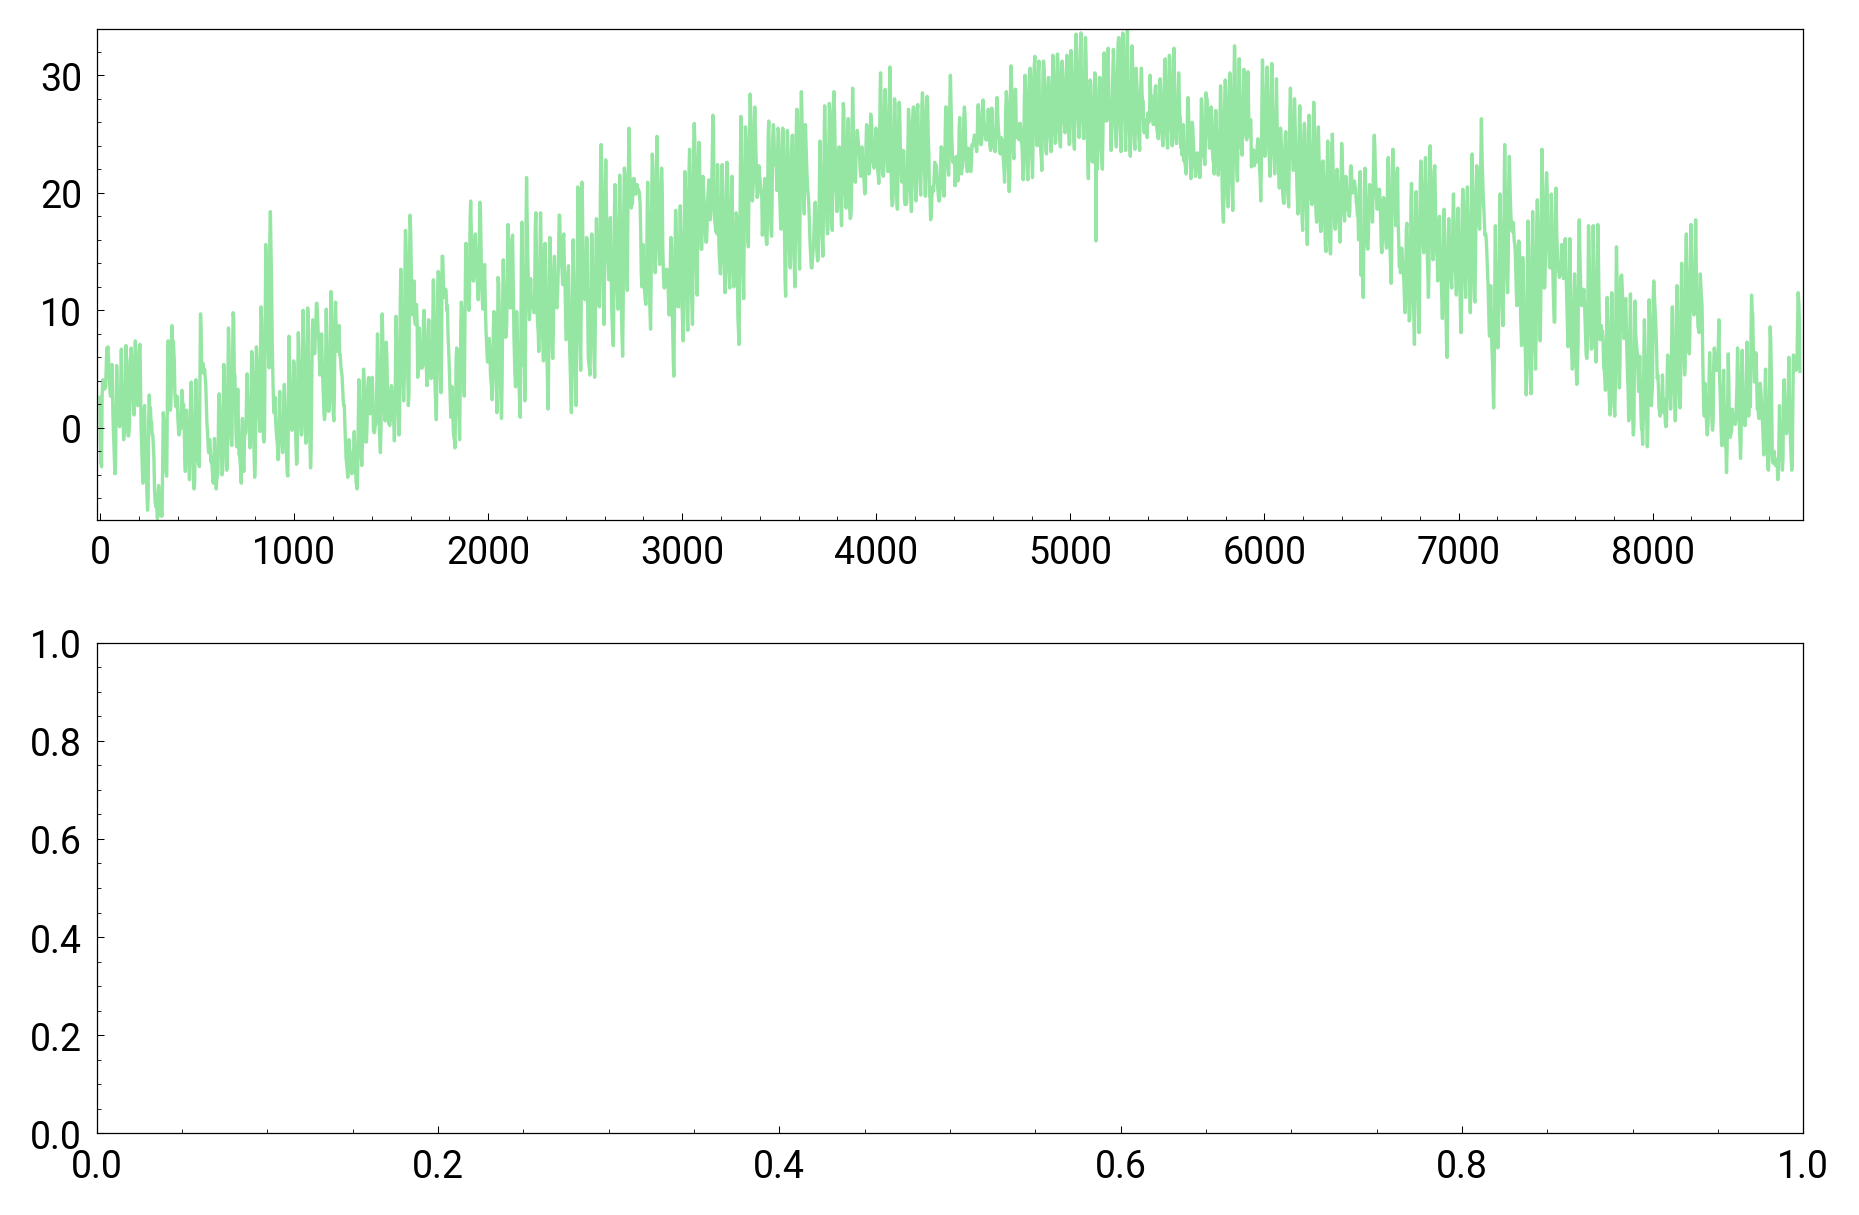

In [8]:
# Set up the subplots
fig, ax = plt.subplots(2, 1, figsize=(dm.cm2in(17), dm.cm2in(11)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.25)

# Common settings
label_pad = 5
line_width = 0.8

# Colors
color_temp = 'dm.green4'
color_cooling = 'dm.blue6'
color_heating = 'dm.red6'

# Plot environmental temperature
ax[0].plot(Toa_list, color=color_temp, label='Environmental temperature [$^{\circ}$C]', linewidth=line_width, alpha=0.7)
ax[0].set_ylabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].set_xticks(np.linspace(0, 8760, 7))
ax[0].set_yticks(np.arange(-10, 41, 10))
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].text(0.01, 0.97, '(a)', transform=ax[0].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')

# Plot loads
ax[1].plot(cooling_load_list / 1000, color=color_cooling, label='Cooling load [kW]', linewidth=line_width, alpha=0.5)
ax[1].plot(heating_load_list / 1000, color=color_heating, label='Heating load [kW]', linewidth=line_width, alpha=0.5)
ax[1].set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax[1].set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad+2)
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].set_xticks(np.linspace(0, 8760, 7))
ax[1].set_yticks(np.arange(0, 31, 10))
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].text(0.01, 0.97, '(b)', transform=ax[1].transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax[1].legend(
    labels=['Cooling load', 'Heating load'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.97, 0.995),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/Fig. 3.png', dpi=600)
plt.savefig('figure/Fig. 3.pdf', dpi=600)
dm.util.save_and_show(fig)

## Fig. 5 냉난방 COP 그래프

In [ ]:
# parameter
T_ev_l = 12
COP_ref = 4.0

# 2d grid for cooling
PLR_cooling = np.linspace(0.2, 1.0, 500)
T_cond_e_cooling = np.linspace(15, 35, 500)
PLR_grid_cooling, T_cond_e_grid_cooling = np.meshgrid(PLR_cooling, T_cond_e_cooling)

# calculate COP for cooling
EIRFTemp_cooling = 0.38 + 0.02 * T_ev_l + 0 * T_ev_l**2 + 0.01 * T_cond_e_grid_cooling + 0 * T_cond_e_grid_cooling**2 + 0 * T_ev_l * T_cond_e_grid_cooling
EIRFPLR_cooling = 0.22 + 0.50 * PLR_grid_cooling + 0.26 * PLR_grid_cooling**2
COP_cooling = PLR_grid_cooling * COP_ref / (EIRFTemp_cooling * EIRFPLR_cooling)

# 2d grid for heating
PLR_heating = np.linspace(0.2, 1.0, 500)
T_0_heating = np.linspace(-15, 25, 500)
PLR_grid_heating, T_0_grid_heating = np.meshgrid(PLR_heating, T_0_heating)

# calculate COP for heating
COP_heating = -7.46 * (PLR_grid_heating - 0.0047 * T_0_grid_heating - 0.477) ** 2 + 0.0941 * T_0_grid_heating + 4.34

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.45, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.55, 1.0, 256))
)

# Set up the figure and axes
fig, (ax_cooling, ax_heating) = plt.subplots(1, 2, figsize=(dm.cm2in(17), dm.cm2in(7)))
plt.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.18, wspace=0.25)

# color
contour_cooling_color = 'dm.white'
contour_heating_color = 'dm.white'

# Common setting
label_pad = 6
tick_pad = 5

# normalize for colorbar
norm_COP_cooling = mcolors.Normalize(vmin=0.0, vmax=6.0)
norm_COP_heating = mcolors.Normalize(vmin=0.0, vmax=7.0)

# Cooling colormap
colormap_cooling = ax_cooling.pcolormesh(T_cond_e_grid_cooling, PLR_grid_cooling, COP_cooling,
                                         shading='auto',
                                         cmap=coolwarm_left.reversed(),
                                         norm=norm_COP_cooling,
                                         rasterized=True)
cbar_cooling = fig.colorbar(colormap_cooling, ax=ax_cooling)
cbar_cooling.set_label('COP [ - ]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar_cooling.ax.tick_params(labelsize=cbar_fontsize)
cbar_cooling.set_ticks(np.arange(0.0, 6.1, 1.0))
cbar_cooling.ax.minorticks_off()

# Cooling contour lines
contour_lines_cooling = ax_cooling.contour(T_cond_e_grid_cooling, PLR_grid_cooling, COP_cooling,
                                         levels=np.arange(3.0, 5.6, 0.5), 
                                         colors=contour_cooling_color,
                                         linewidths=0.6,
                                         alpha=0.9)
ax_cooling.clabel(contour_lines_cooling, 
                  inline=True, 
                  fontsize=tick_fontsize-1, 
                  fmt='%.1f')

# Cooling graph
ax_cooling.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax_cooling.set_ylabel('Part load ratio [ - ]', fontsize=label_fontsize, labelpad=label_pad)
ax_cooling.set_xlim(15, 35)
ax_cooling.set_ylim(0.2, 1.0)
ax_cooling.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax_cooling.tick_params(axis='both', which='minor', labelsize=tick_fontsize, pad=tick_pad)
ax_cooling.set_xticks(np.arange(15, 36, 5))
ax_cooling.set_yticks(np.arange(0.2, 1.1, 0.2))
ax_cooling.text(0.02, 1.09, '(a) Cooling mode', transform=ax_cooling.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')

# Heating colormap
colormap_heating = ax_heating.pcolormesh(T_0_grid_heating, PLR_grid_heating, COP_heating,
                                         shading='auto',
                                         cmap=coolwarm_right,
                                         norm=norm_COP_heating,
                                         rasterized=True)
cbar_heating = fig.colorbar(colormap_heating, ax=ax_heating)
cbar_heating.set_label('COP [ - ]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar_heating.ax.tick_params(labelsize=cbar_fontsize)
cbar_heating.set_ticks(np.arange(0.0, 7.1, 1.0))
cbar_heating.ax.minorticks_off()

# Heating contour lines
contour_lines_heating = ax_heating.contour(T_0_grid_heating, PLR_grid_heating, COP_heating,
                                         levels=np.arange(1.0, 7.1, 1.0),
                                         colors=contour_heating_color,
                                         linewidths=0.6,
                                         alpha=0.9)
ax_heating.clabel(contour_lines_heating, 
                 inline=True, 
                 fontsize=tick_fontsize-1, 
                 fmt='%.1f')

# Heating graph
ax_heating.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax_heating.set_ylabel('Part load ratio [ - ]', fontsize=label_fontsize, labelpad=label_pad)
ax_heating.set_xlim(-10, 25)
ax_heating.set_ylim(0.2, 1.0)
ax_heating.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax_heating.tick_params(axis='both', which='minor', labelsize=tick_fontsize, pad=tick_pad)
ax_heating.set_xticks(np.arange(-15, 26, 10))
ax_heating.set_yticks(np.arange(0.2, 1.1, 0.2))
ax_heating.text(0.01, 1.09, '(b) Heating mode', transform=ax_heating.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')


# # Save and show the figure
plt.savefig('figure/Fig. 5.png', dpi=600)
# plt.savefig('figure/Fig. 5.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)

## Fig. 6 Fan 특성곡선

In [ ]:
fan_model = enex.Fan()

# 유량 범위
int_flow_range = np.linspace(1.0, 3.0, 100)
ext_flow_range = np.linspace(1.5, 3.5, 100)

# Common settings
label_pad = 3
line_width = 0.8
spine_width = 0.5
tick_pad = 5

# Color
colors = ['dm.soft blue', 'dm.cool green', 'dm.red5']

fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(17), dm.cm2in(5)))
plt.subplots_adjust(left=0.07, right=0.86, top=0.87, bottom=0.18, wspace=0.8, hspace=0.5)

fan_labels = ['Indoor unit', 'Outdoor unit']
flow_ranges = [int_flow_range, ext_flow_range]
ylim_pressure = [(130, 210), (250, 370)]
yticks_pressure = [np.linspace(130, 210, 5), np.linspace(250, 370, 5)]
ylim_efficiency = [(50, 70), (50, 70)]
yticks_efficiency = [np.linspace(50, 70, 5), np.linspace(50, 70, 5)]
ylim_power = [(200, 1200), (600, 2200)]
yticks_power = [np.linspace(200, 1200, 5), np.linspace(600, 2200, 5)]
xlims = [(1.0, 3.0), (1.5, 3.5)]
xticks = [np.arange(1.0, 3.1, 0.5), np.arange(1.5, 3.6, 0.5)]

for ax, fan, label, flow_range, ylim_p, yticks_p, ylim_e, yticks_e, ylim_pow, yticks_pow, xlim, xtick in zip(
    axes, fan_model.fan_list, fan_labels, flow_ranges, ylim_pressure, yticks_pressure, ylim_efficiency, yticks_efficiency, ylim_power, yticks_power, xlims, xticks
):
    pressure = fan_model.get_pressure(fan, flow_range)
    efficiency = fan_model.get_efficiency(fan, flow_range)
    power = fan_model.get_power(fan, flow_range)

    # Pressure drop - Left y-axis
    ax.set_xlabel('Air flow Rate [m$^3$/s]', fontsize=label_fontsize, labelpad=label_pad)
    ax.set_ylabel('Pressure drop [Pa]', color=colors[0], fontsize=label_fontsize, labelpad=label_pad)
    ax.plot(flow_range, pressure, color=colors[0], label='Pressure drop', linewidth=line_width)
    ax.tick_params(axis='x', labelsize=tick_fontsize, pad=tick_pad)
    ax.tick_params(axis='y', labelsize=tick_fontsize, colors=colors[0])
    ax.set_xlim(xlim)
    ax.set_xticks(xtick)
    ax.set_ylim(ylim_p)
    ax.set_yticks(yticks_p)
    ax.spines['left'].set_color(colors[0])

    # Efficiency - First right y-axis
    ax2 = ax.twinx()
    ax2.set_ylabel('Efficiency [%]', color=colors[1], fontsize=label_fontsize, labelpad=label_pad)
    ax2.plot(flow_range, efficiency * 100, color=colors[1], label=f'{label} Efficiency', linewidth=line_width)
    ax2.tick_params(axis='y', labelsize=tick_fontsize, colors=colors[1])
    ax2.set_ylim(ylim_e)
    ax2.set_yticks(yticks_e)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_color(colors[1])

    # Power - Second right y-axis
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('axes', 1.23))
    ax3.set_ylabel('Power [W]', color=colors[2], fontsize=label_fontsize, labelpad=label_pad)
    ax3.plot(flow_range, power, color=colors[2], label=f'{label} Power', linewidth=line_width)
    ax3.tick_params(axis='y', labelsize=tick_fontsize, colors=colors[2])
    ax3.set_ylim(ylim_pow)
    ax3.set_yticks(yticks_pow)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['right'].set_color(colors[2])

    ax.grid(True)

    # remove minor ticks
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='y', which='minor', right=False)
    ax2.tick_params(axis='y', which='minor', right=False)
    ax3.tick_params(axis='y', which='minor', right=False)

    # Add titles to each subplot
    ax.text(0.01, 1.13, f'({chr(97 + axes.tolist().index(ax))}) {label} fan', transform=ax.transAxes, fontsize=subtitle_fontsize, va='top', ha='left')

# Save and show
plt.savefig('figure/Fig. 6.png', dpi=600)
plt.savefig('figure/Fig. 6.pdf', dpi=600)
dm.util.save_and_show(fig)

## Fig. 8 Energy efficiency

In [ ]:
# cooling COP 최대일 때의 날짜, 환경온도, 실내온도, 냉방부하
max_cooling_COP_index = ASHP_cooling_COP_filtered.index(max(ASHP_cooling_COP_filtered))
print("Cooling COP Maximum Details: =======================================")
print("Maximum Cooling COP:", max(ASHP_cooling_COP_filtered))
print("Date:", Date_cooling_list_filtered[max_cooling_COP_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_cooling_list_filtered[max_cooling_COP_index]))
print("Indoor Temperature (Tia): {:.1f}".format(Tia_cooling_list_filtered[max_cooling_COP_index]))
print("Cooling Load: {:.1f}".format(cooling_load_list_filtered[max_cooling_COP_index]))
print()

# cooling COP 최소일 때의 날짜, 환경온도, 실내온도, 냉방부하
min_cooling_COP_index = ASHP_cooling_COP_filtered.index(min(ASHP_cooling_COP_filtered))
print("Cooling COP Minimum Details: ======================================")
print("Minimum Cooling COP:", min(ASHP_cooling_COP_filtered))
print("Date:", Date_cooling_list_filtered[min_cooling_COP_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_cooling_list_filtered[min_cooling_COP_index]))
print("Indoor Temperature (Tia): {:.1f}".format(Tia_cooling_list_filtered[min_cooling_COP_index]))
print("Cooling Load: {:.1f}".format(cooling_load_list_filtered[min_cooling_COP_index]))
print()

# heating COP 최대일 때의 날짜, 환경온도, 실내온도, 난방부하
max_heating_COP_index = ASHP_heating_COP_filtered.index(max(ASHP_heating_COP_filtered))
print("Heating COP Maximum Details: =======================================")
print("Maximum Heating COP:", max(ASHP_heating_COP_filtered))
print("Date:", Date_heating_list_filtered[max_heating_COP_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_heating_list_filtered[max_heating_COP_index]))
print("Indoor Temperature (Tia): {:.1f}".format(Tia_heating_list_filtered[max_heating_COP_index]))
print("Heating Load: {:.1f}".format(heating_load_list_filtered[max_heating_COP_index]))
print()

# heating COP 최소일 때의 날짜, 환경온도, 실내온도, 난방부하
min_heating_COP_index = ASHP_heating_COP_filtered.index(min(ASHP_heating_COP_filtered))
print("Heating COP Minimum Details: =======================================")
print("Minimum Heating COP:", min(ASHP_heating_COP_filtered))
print("Date:", Date_heating_list_filtered[min_heating_COP_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_heating_list_filtered[min_heating_COP_index]))
print("Indoor Temperature (Tia): {:.1f}".format(Tia_heating_list_filtered[min_heating_COP_index]))
print("Heating Load: {:.1f}".format(heating_load_list_filtered[min_heating_COP_index]))

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.45, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.55, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(17), dm.cm2in(8)))
plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=2, vmax=4.5)
norm_heating = mcolors.Normalize(vmin=2, vmax=4.5)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 1000 for load in cooling_load_list_filtered], 
                 c=[eff for eff in ASHP_cooling_COP_filtered],
                 cmap=coolwarm_left.reversed(), 
                 s=2.5, alpha=1.0, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
cbar1.set_ticks(np.arange(2, 4.6, 0.5))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 1000 for load in heating_load_list_filtered], 
                 c=[eff for eff in ASHP_heating_COP_filtered], 
                 cmap=coolwarm_right, 
                 s=2.5, alpha=1.0, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_ticks(np.arange(2, 4.6, 0.5))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Energy efficiency (COP$_{sys}$) [ - ]', fontsize=cbar_fontsize, labelpad=label_pad+2)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 23, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 30)

# label
ax.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.linspace(0, 30, 7))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

plt.savefig('figure/Fig. 8.png', dpi=600)
dm.util.save_and_show(fig)

## Fig. 9 Exergy efficiency

In [ ]:
# cooling exergy efficiency 최대일 때의 날짜, 환경온도, 실내온도, 냉방부하
max_cooling_exergy_index = ASHP_cooling_exergy_effi_filtered.index(max(ASHP_cooling_exergy_effi_filtered))
print("Cooling Exergy Efficiency Maximum Details: =======================================")
print("Maximum Cooling Exergy Efficiency: {:.1f}".format(max(ASHP_cooling_exergy_effi_filtered) * 100))
print("Date:", Date_cooling_list_filtered[max_cooling_exergy_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_cooling_list_filtered[max_cooling_exergy_index]))
# print("Indoor Temperature (Tia): {:.1f}".format(Tia_cooling_list_filtered[max_cooling_exergy_index]))
print("Cooling Load: {:.1f}".format(cooling_load_list_filtered[max_cooling_exergy_index]))
print()

# cooling exergy efficiency 최소일 때의 날짜, 환경온도, 실내온도, 냉방부하
min_cooling_exergy_index = ASHP_cooling_exergy_effi_filtered.index(min(ASHP_cooling_exergy_effi_filtered))
print("Cooling Exergy Efficiency Minimum Details: ======================================")
print("Minimum Cooling Exergy Efficiency: {:.1f}".format(min(ASHP_cooling_exergy_effi_filtered) * 100))
print("Date:", Date_cooling_list_filtered[min_cooling_exergy_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_cooling_list_filtered[min_cooling_exergy_index]))
# print("Indoor Temperature (Tia): {:.1f}".format(Tia_cooling_list_filtered[min_cooling_exergy_index]))
print("Cooling Load: {:.1f}".format(cooling_load_list_filtered[min_cooling_exergy_index]))
print()

# heating exergy efficiency 최대일 때의 날짜, 환경온도, 실내온도, 난방부하
max_heating_exergy_index = ASHP_heating_exergy_effi_filtered.index(max(ASHP_heating_exergy_effi_filtered))
print("Heating Exergy Efficiency Maximum Details: =======================================")
print("Maximum Heating Exergy Efficiency: {:.1f}".format(max(ASHP_heating_exergy_effi_filtered) * 100))
print("Date:", Date_heating_list_filtered[max_heating_exergy_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_heating_list_filtered[max_heating_exergy_index]))
# print("Indoor Temperature (Tia): {:.1f}".format(Tia_heating_list_filtered[max_heating_exergy_index]))
print("Heating Load: {:.1f}".format(heating_load_list_filtered[max_heating_exergy_index]))
print()

# heating exergy efficiency 최소일 때의 날짜, 환경온도, 실내온도, 난방부하
min_heating_exergy_index = ASHP_heating_exergy_effi_filtered.index(min(ASHP_heating_exergy_effi_filtered))
print("Heating Exergy Efficiency Minimum Details: =======================================")
print("Minimum Heating Exergy Efficiency: {:.1f}".format(min(ASHP_heating_exergy_effi_filtered) * 100))
print("Date:", Date_heating_list_filtered[min_heating_exergy_index])
print("Outdoor Temperature (Toa): {:.1f}".format(Toa_heating_list_filtered[min_heating_exergy_index]))
# print("Indoor Temperature (Tia): {:.1f}".format(Tia_heating_list_filtered[min_heating_exergy_index]))
print("Heating Load: {:.1f}".format(heating_load_list_filtered[min_heating_exergy_index]))

In [ ]:
# coolwarm 컬러맵의 왼쪽 절반만 사용
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', get_cmap('coolwarm')(np.linspace(0, 0.45, 256))
)

# coolwarm 컬러맵의 오른쪽 절반만 사용
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', get_cmap('coolwarm')(np.linspace(0.55, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(17), dm.cm2in(8)))
plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Common setting
label_pad = 8
line_width = 0.6

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=0, vmax=20)
norm_heating = mcolors.Normalize(vmin=0, vmax=32)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 1000 for load in cooling_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_cooling_exergy_effi_filtered],
                 cmap=coolwarm_left.reversed(), 
                 s=2.5, alpha=1.0, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
cbar1.set_ticks(np.arange(0, 21, 5))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)
cbar1.ax.minorticks_off()

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 1000 for load in heating_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_heating_exergy_effi_filtered], 
                 cmap=coolwarm_right, 
                 s=2.5, alpha=1.0, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_ticks(np.arange(0, 33, 8))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad+2)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)
cbar2.ax.minorticks_off()

ax.axvline(x=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint temperature')
ax.text(20.5, 23, 'Setpoint temperature', rotation=90, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 30)

# label
ax.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.linspace(0, 30, 7))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

# plt.savefig('figure/Fig. 9.png', dpi=600)
dm.util.save_and_show(fig)

## Fig. 11 net exergy

In [148]:
from matplotlib.ticker import AutoMinorLocator  # 파일 상단 또는 이 블록 위

# 원하는 마이너 틱 개수(축별)
x_minor_between = 1   # X축: 메이저 틱 사이 마이너 4개
y_minor_between = 1   # Y축: 메이저 틱 사이 마이너 2개


xmin, xmax, xint, xmar = -10, 40, 5, 0
ymin, ymax, yint, ymar =  0, 6, 1, 0

# constant
c_a = 1005 # Specific heat capacity of air [J/kgK]
rho_a = 1.225 # Density of air [kg/m³]
k_a = 0.0257 # Thermal conductivity of air [W/mK]


T_range = np.arange(xmin, xmax+xint, 0.1)
T_a_int_in = 22

T0_cooling = -6
T0_heating = 33
T0 = np.array([T0_cooling, T0_heating])

T_range_K = enex.C2K(T_range)
T0_K = enex.C2K(T0)


dV_int_unit = 1 # 환기량 [m³/s]
y1 = c_a * rho_a * dV_int_unit * ((T_range_K - T0_K[0]) - T0_K[0] * np.log(T_range_K / T0_K[0]))*enex.W2kW
y2 = c_a * rho_a * dV_int_unit * ((T_range_K - T0_K[1]) - T0_K[1] * np.log(T_range_K / T0_K[1]))*enex.W2kW

T_set = 22
T_a_int_out_cooling = 12
T_a_int_out_heating = 32

# 3) Figure 생성
fig = plt.figure(
    figsize=(dm.cm2in(14), dm.cm2in(7)),
    dpi=300
)

# 4) GridSpec 레이아웃
nrows, ncols = 1, 1
gs = fig.add_gridspec(
    nrows=nrows, ncols=ncols,
    left=0.16, right=0.98, top=0.96, bottom=0.18,
    hspace=0.10, wspace=0.10
)

# 5) 2중 for 문으로 축 생성 및 순회 (단일 플롯이어도 유지)
for row in range(nrows):
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])

        # 6) 데이터 플로팅 (계단형 라인)
        lw = 1
        line1, = ax.plot(
            T_range, y1, 
            c= 'dm.red4', lw=lw, label=f'Exergy rate of unit air flow rate in winter ($T_0$ = - {abs(T0_cooling)} °C)',
        )
        line2, = ax.plot(
            T_range, y2,
            c= 'dm.blue3', lw=lw, label=f'Exergy rate of unit air flow rate in summer ($T_0$ = {T0_heating} °C)',
        )
        # T_set°C
        ds_lw = 0.5 # dashed line width
        c1 = 'dm.teal'
        c2 = 'dm.blue'
        c3 = 'dm.red'
        ax.axvline(x=T_set, color=c1 + '6', linestyle='--', linewidth=ds_lw, zorder=0)
        # ax.axvline(x=T_a_int_out_cooling, color=c2 + '6', linestyle='--', linewidth=ds_lw, zorder=0)
        # ax.axvline(x=T_a_int_out_heating, color=c3 + '6', linestyle='--', linewidth=ds_lw, zorder=0)

        dx = -0.3
        ax.text(T_set + dx, ymax*0.95, 'Setpoint', rotation=90, fontsize=fs['setpoint'], color=c1 + '6', ha='right', va= 'top')
        # ax.text(T_a_int_out_cooling + dx, ymax*0.95, 'Internal unit outlet air temp (cooling)', rotation=90, fontsize=text_fs, color=c2 + '8', ha='right', va= 'top')
        # ax.text(T_a_int_out_heating + dx, ymax*0.95, 'Internal unit outlet air temp (heating)', rotation=90, fontsize=text_fs, color=c3 + '8', ha= 'right', va='top')

        # 교차점 계산 및 scatter plot 추가
        # 1번 점선 (x=T_set)이 line1, line2와 만나는 점
        ss = 6 # scatter size
        sc1 = 'dm.red8'
        sc2 = 'dm.blue8'
        y1_at_T_set = np.interp(T_set, T_range, y1)
        y2_at_T_set = np.interp(T_set, T_range, y2)
        ax.scatter([T_set, T_set], [y1_at_T_set, y2_at_T_set], color=[sc1, sc2], s=ss, zorder=5) # s는 마커 크기
                # --- NEW: scatter 위에 y값 표시(소수점 한자리 '절삭') ---

        for x, y, col in [(T_set, y1_at_T_set, sc1), (T_set, y2_at_T_set, sc2)]:
            ax.annotate(
                f"{y:.2f}",
                (x, y),
                textcoords="offset points",
                xytext=(0, 4),           # 점 바로 위로 6pt 오프셋
                ha="center",
                va="bottom",
                fontsize=fs['text']+1,    # 기존에 사용 중인 폰트 크기 변수 재사용
                color=col,               # 스캐터와 동일한 색상
                zorder=6
            )

        # 3번 점선 (x=T_a_int_out_heating)이 line1과 만나는 점
        y1_at_T_a_int_out_heating = np.interp(T_a_int_out_heating, T_range, y1)
        # ax.scatter(T_a_int_out_heating, y1_at_T_a_int_out_heating, color=sc1, s=ss, zorder=5)

        # 2번 점선 (x=T_a_int_out_cooling)이 line2와 만나는 점
        y2_at_T_a_int_out_cooling = np.interp(T_a_int_out_cooling, T_range, y2)
        # ax.scatter(T_a_int_out_cooling, y2_at_T_a_int_out_cooling, color=sc2, s=ss, zorder=5)
        
        y1_dy = y1_at_T_a_int_out_heating - y1_at_T_set
        y2_dy = y2_at_T_a_int_out_cooling - y2_at_T_set


        # 7) 축/눈금/범위 등 그래프 요소
        ax.set_xlabel('Indoor air temperature [°C]', labelpad = pad['label'], fontsize=fs['label'])
        ax.set_ylabel('Exergy rate in air flow [kW/(m$^3$/s)]', labelpad = pad['label'], fontsize=fs['label'])
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        ax.set_xticks(np.arange(xmin, xmax + 1, xint))
        ax.set_yticks(np.arange(ymin, ymax + 1, yint))
        
        ax.tick_params(axis='both', which='major', direction='in',  pad=pad['tick'], labelsize=fs['tick'])
        ax.tick_params(axis='both', which='minor', direction='in',  pad=pad['tick'], labelsize=fs['tick'])
        
        # 마이너 틱 로케이터 설정 (축별로 개수 조절)
        ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_between + 1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_between + 1))

        # (선택) 격자
        ax.grid(True, which='major', alpha=0.25)

        # 8) 범례
        handles = [line1, line2]
        labels = [h.get_label() for h in handles]
        ax.legend(handles, labels, loc='upper left', fontsize=fs['legend'], frameon=False, handletextpad=1)

# 9) 레이아웃 최적화 (tight_layout 사용 금지)
dm.simple_layout(fig)
plt.savefig('figure/Fig. 12.png', dpi=600)
plt.savefig('figure/Fig. 12.svg', dpi=600, transparent=True)

dm.save_and_show(fig)

# 결과 확인
# plt.show()
# (노트북/스크립트 환경에 따라 dm.save_and_show(fig) 사용 가능)


## Fig. 11 월별 환경온도 + 엑서지 input, consumption, output

In [ ]:
# 월별 데이터를 그룹화하기 위해 'Month' 열 생성
weekday_df['Month'] = weekday_df['Date/Time_clean'].str.split('/').str[0].astype(int)

# 월별 그룹화
grouped = weekday_df.groupby('Month')

# 월별 리스트 생성
monthly_exergy_input = []
monthly_exergy_consumption = []
monthly_exergy_output = []
monthly_avg_COP = []
monthly_exergy_efficiency = []

# 월별 온도 리스트 생성
monthly_avg_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].mean().tolist()
monthly_min_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].min().tolist()
monthly_max_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].max().tolist()

for month, group in grouped:
    input_exergy = 0
    consumption_exergy = 0
    output_exergy = 0
    
    total_cooling_exergy_efficiency = 0
    total_heating_exergy_efficiency = 0
    total_cooling_COP = 0
    total_heating_COP = 0
    cooling_count = 0
    heating_count = 0

    for _, row in group.iterrows():
        Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
        Tia = row['CORE_ZN:Zone Air Temperature [C](TimeStep)']
        cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] / 3600
        heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600

        if cooling_load > 0:
            ASHP_cooling = enex.AirSourceHeatPump_cooling()
            ASHP_cooling.T0 = Toa
            ASHP_cooling.T_a_room = 22
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.Q_r_max = max(cooling_load_list)
            ASHP_cooling.system_update()
            if ASHP_cooling.X_eff > 0:
                input_exergy += (ASHP_cooling.E_cmp + ASHP_cooling.E_fan_int + ASHP_cooling.E_fan_ext) * 3600
                output_exergy += (ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in) * 3600
                total_cooling_COP += ASHP_cooling.COP_sys
                total_cooling_exergy_efficiency += ASHP_cooling.X_eff
                cooling_count += 1
            else:
                cooling_count += 0
        else:
            cooling_count += 0
            
        if heating_load > 0:
            ASHP_heating = enex.AirSourceHeatPump_heating()
            ASHP_heating.T0 = Toa
            ASHP_heating.T_a_room = 22
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.Q_r_max = max(heating_load_list)
            ASHP_heating.system_update()
            if ASHP_heating.X_eff > 0:
                input_exergy += (ASHP_heating.E_cmp + ASHP_heating.E_fan_int + ASHP_heating.E_fan_ext) * 3600
                output_exergy += (ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in) * 3600
                total_heating_COP += ASHP_heating.COP_sys
                total_heating_exergy_efficiency += ASHP_heating.X_eff
                heating_count += 1
            else:
                heating_count += 0
        else:
            heating_count += 0

    consumption_exergy = input_exergy - output_exergy

    monthly_exergy_input.append(input_exergy / 1000000000)
    monthly_exergy_consumption.append(consumption_exergy / 1000000000)
    monthly_exergy_output.append(output_exergy / 1000000000)

    avg_exergy_efficiency = (total_cooling_exergy_efficiency + total_heating_exergy_efficiency) / (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None
    monthly_exergy_efficiency.append(avg_exergy_efficiency * 100 if avg_exergy_efficiency is not None else 0)
    avg_COP = (total_cooling_COP + total_heating_COP) / (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None
    monthly_avg_COP.append(avg_COP)

In [ ]:
# 월별 평균 엑서지 효율 및 COP 확인
for month in range(1, 13):
    print(f"Month: {month}, Exergy Efficiency: {monthly_exergy_output[month-1]:.1f}%, Average COP: {monthly_avg_COP[month-1]:.1f}")

In [ ]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(1, 13)

# Create figure with 2 subplots vertically stacked
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(dm.cm2in(17), dm.cm2in(11)), gridspec_kw={'height_ratios': [1.0, 1.4]})
plt.subplots_adjust(left=0.08, right=0.92, top=0.95, bottom=0.08, wspace=0.2, hspace=0.2)

# Colors
fill_color = 'dm.gray1'
min_temp_color = 'dm.blue5'
max_temp_color = 'dm.red5'
avg_temp_color = 'dm.gray8'
percentage_color = 'dm.black'
avg_cop_color = 'dm.orange6'

# Common setting
marker_size = 1.5
line_width = 0.5
label_pad = 5

# --- FIRST SUBPLOT: TEMPERATURE ---
ax1.fill_between(x, monthly_min_temp, monthly_max_temp, color=fill_color, alpha=0.6)

# ax1 plot
ax1.plot(x, monthly_max_temp, color=max_temp_color, linewidth=line_width, label='Max', marker='o', markersize=marker_size)
ax1.plot(x, monthly_avg_temp, color=avg_temp_color, linewidth=line_width, label='Avg', marker='o', markersize=marker_size)
ax1.plot(x, monthly_min_temp, color=min_temp_color, linewidth=line_width, label='Min', marker='o', markersize=marker_size)

# Limit
ax1.set_xlim(0.5, 12.5)
ax1.set_ylim(-10, 40)

# Tick
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=tick_fontsize)
ax1.set_yticks(np.arange(-10, 41, 10))
ax1.set_yticklabels(np.arange(-10, 41, 10), fontsize=tick_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', which='minor', bottom=False)
ax2.text(0.01, 0.97, '(a)', transform=ax1.transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')

# Axis and title
ax1.set_ylabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(
    loc='upper right', ncol=3, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.99, 1.01),
    handlelength=1.8
)

ax1.axhline(y=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint')
ax1.text(0.6, 24, 'Setpoint', rotation=0, fontsize=setpoint_fontsize, color='dm.teal6', ha='left', va='center')

# --- SECOND SUBPLOT: EXERGY STACKED BAR ---
# Exergy input
total_exergy = np.array(monthly_exergy_input)

# Common settings
bar_width = 0.57
spine_width = 0.5

# Colors
colors = ['dm.gray2', 'dm.green3', 'dm.orange7']
edge_color = 'dm.gray8'

# Stacked bar plot
bar_top = ax2.bar(x, monthly_exergy_consumption, bar_width, bottom=monthly_exergy_output, 
                 label='Exergy consumption', color=colors[0], alpha=1.0, zorder=3)
bar_bottom = ax2.bar(x, monthly_exergy_output, bar_width, 
                    label='Exergy output', color=colors[1], alpha=0.75, zorder=3)

# Add percentage labels
for i in range(len(labels)):
    x_pos = x[i]
    consumption = monthly_exergy_consumption[i]
    output = monthly_exergy_output[i]
    consumption_ratio = consumption * 100 / total_exergy[i]
    output_ratio = output * 100 / total_exergy[i]
    ax2.text(
        x_pos, output + consumption / 2,
        f'{consumption_ratio:.1f}%',
        ha='center', va='center',
        fontsize=text_fontsize, color=percentage_color, zorder=4)
    ax2.text(
        x_pos, output / 2,
        f'{output_ratio:.1f}%',
        ha='center', va='center',
        fontsize=text_fontsize, color=percentage_color, zorder=4)
    
# Add rectangle outlines
for i in range(len(labels)):
    total_height = monthly_exergy_consumption[i] + monthly_exergy_output[i]
    rect = plt.Rectangle(
        (x[i] - bar_width / 2, 0),
        bar_width,
        total_height,
        linewidth=line_width,
        edgecolor=edge_color,
        facecolor='none',
        alpha=0.7, zorder=3
    )
    ax2.add_patch(rect)

# Create custom legend element
from matplotlib.patches import Patch
input_legend = Patch(
    facecolor='none', edgecolor=edge_color,
    linewidth=line_width, alpha=0.7,
    label='Exergy input'
)

# Label
ax2.set_ylabel('Exergy [GWh]', fontsize=label_fontsize, labelpad=label_pad+5)

# Limit
ax2.set_xlim(0.5, 12.5)
ax2.set_ylim(0, 5)

# Tick
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=tick_fontsize)
ax2.set_ylim(0.0, 5.0)
ax2.set_yticklabels(np.arange(0, 6, 1), fontsize=tick_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.tick_params(axis='x', which='major', bottom=False)
ax2.tick_params(axis='x', which='minor', bottom=False)
ax2.text(0.01, 0.97, '(b)', transform=ax2.transAxes, fontsize=subtitle_fontsize, fontweight='bold', va='top', ha='left')
ax2.spines['right'].set_visible(False)

# Add secondary y-axis for monthly_avg_COP
ax2_right = ax2.twinx()
ax2_right.plot(x, monthly_avg_COP, color=avg_cop_color, linewidth=line_width, label='COP', marker='o', markersize=marker_size)
ax2_right.set_ylabel('Average COP$_{sys}$ [ - ]', fontsize=label_fontsize, labelpad=label_pad + 5, color=avg_cop_color)
ax2_right.set_ylim(0.0, 5.0)
ax2_right.set_yticks(np.arange(0.0, 5.1, 1.0))
ax2_right.tick_params(axis='y', labelsize=tick_fontsize, color=avg_cop_color, labelcolor=avg_cop_color)
ax2_right.tick_params(axis='y', which='minor', color=avg_cop_color)
ax2_right.spines['right'].set_color(avg_cop_color)
ax2_right.spines['right'].set_linewidth(spine_width)

# Grid
ax2.grid(True, linestyle='--', alpha=0.6, zorder=1)
ax2.xaxis.grid(False)

# Legend (combined for ax2 and ax2_right, 4 columns)
handles_left, labels_left = ax2.get_legend_handles_labels()
handles_left.insert(0, input_legend)
labels_left.insert(0, 'Exergy input')

handles_right, labels_right = ax2_right.get_legend_handles_labels()

# Combine handles and labels
handles_combined = handles_left + handles_right
labels_combined = labels_left + labels_right

legend = ax2.legend(
    handles_combined, labels_combined,
    loc='upper right', ncol=4, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.0, labelspacing=1.0,
    bbox_to_anchor=(0.99, 1.01),
    handlelength=1.8
)

# plt.savefig('figure/Fig. 11.png', dpi=600)
plt.savefig('figure/Fig. 11.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)

In [ ]:
np.round(monthly_avg_COP, 2)

## Fig. 8/Fig. 9 COP & Exergy 격자 형태

In [91]:
def grid_stats(Toa, Load, COP, bins_x, bins_y):
    avg_COP = np.full((len(bins_y)-1, len(bins_x)-1), np.nan)
    for i in range(len(bins_x)-1):  # x축 (Toa)
        for j in range(len(bins_y)-1):  # y축 (Load)
            mask = (
                (Toa >= bins_x[i]) & (Toa < bins_x[i+1]) &
                (Load >= bins_y[j]) & (Load < bins_y[j+1])
            )
            if np.any(mask):
                avg_COP[j,i] = np.mean(COP[mask])
    return avg_COP, bins_x, bins_y

In [146]:
# =========================
# 0) 한 곳에서 모두 수정 (튜닝 파라미터)
# =========================
# Colormap 설정
CMAP_BASE_NAME       = 'coolwarm'
CMAP_LEFT_RANGE      = (0.00, 0.45)   # 냉방 패널용 구간
CMAP_RIGHT_RANGE     = (0.55, 1.00)   # 난방 패널용 구간
REVERSE_LEFT_CMAP    = True           # 냉방 colormap 반전 여부

# 격자/범위
BIN_TEMP             = 2.5            # x격자(외기온, °C)
BIN_LOAD             = 5.0            # y격자(부하, kW)
X_RANGE              = (-10, 35)      # x축 범위(°C)
Y_RANGE              = (0, 30)        # y축 범위(kW)

# COP 스케일(양 패널 동일)
COP_VMIN, COP_VMAX, COP_VTICK = 1.5, 4.0, 0.5

# 격자 테두리/그리드/틱
GRID_RECT_LW         = 1.0
EDGE_COLOR_COOL      = 'white'
EDGE_COLOR_HEAT      = 'dm.white'
MAJOR_GRID_LS        = '--'
MAJOR_GRID_ALPHA     = 0.5
MINOR_X_LEN          = 1.6
MINOR_X_COLOR        = 'dm.gray7'

# ★ 텍스트 색 판단용 밝기 컷오프(0=검정, 1=흰색) — 필요시 0.50~0.60 조정
LUMINANCE_CUTOFF     = 0.5

# Setpoint
SETPOINT_VALUE       = 22
SETPOINT_LS          = '--'
SETPOINT_LW          = 0.6
SETPOINT_COLOR       = 'dm.teal6'
SETPOINT_TEXT        = 'Setpoint'
SETPOINT_TX_X        = 20.8
SETPOINT_TX_Y        = 26.2
SETPOINT_TX_ROT      = 90

# Figure/레이아웃
FIG_W_CM, FIG_H_CM   = 17, 13
MARGINS              = dict(left=0.07, right=0.89, top=0.95, bottom=0.10)
HSPACE               = 0.25

# 컬러바 위치/크기(축 바깥 개별 배치)
CBAR_W               = 0.018
CBAR_OFF_H           = 0.025  # 축 bbox 오른쪽으로의 거리(정규 좌표)

# 패널 라벨
PANEL_A              = '(a)'
PANEL_B              = '(b)'

# =========================
# 1) Colormap 준비
# =========================
_coolwarm = cm.get_cmap(CMAP_BASE_NAME)
coolwarm_left  = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left',  _coolwarm(np.linspace(*CMAP_LEFT_RANGE, 256))
)
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', _coolwarm(np.linspace(*CMAP_RIGHT_RANGE, 256))
)
CMAP_COOL = coolwarm_left.reversed() if REVERSE_LEFT_CMAP else coolwarm_left
CMAP_HEAT = coolwarm_right

# =========================
# 2) 데이터 & 빈 (원 코드와 동일)
# =========================
# Cooling
Toa_c  = np.array(Toa_cooling_list_filtered)
Load_c = np.array(cooling_load_list_filtered) / 1000.0
COP_c  = np.array(ASHP_cooling_COP_filtered)

# Heating
Toa_h  = np.array(Toa_heating_list_filtered)
Load_h = np.array(heating_load_list_filtered) / 1000.0
COP_h  = np.array(ASHP_heating_COP_filtered)

bins_x = np.arange(X_RANGE[0], X_RANGE[1] + BIN_TEMP, BIN_TEMP)
bins_y = np.arange(Y_RANGE[0], Y_RANGE[1] + BIN_LOAD, BIN_LOAD)

# 평균 COP 격자 계산
avg_c, xedges, yedges = grid_stats(Toa_c, Load_c, COP_c, bins_x, bins_y)
avg_h, _,      _      = grid_stats(Toa_h, Load_h, COP_h, bins_x, bins_y)

# =========================
# 3) 플롯
# =========================
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)), sharex=False, sharey=True)
plt.subplots_adjust(**MARGINS, hspace=HSPACE)

# 패널 파라미터(루프용)
panels = [
    dict(ax_idx=0, avg=avg_c, cmap=CMAP_COOL, edge_color=EDGE_COLOR_COOL,
         y_label='Cooling load [kW]', tag=PANEL_A),
    dict(ax_idx=1, avg=avg_h, cmap=CMAP_HEAT, edge_color=EDGE_COLOR_HEAT,
         y_label='Heating load [kW]', tag=PANEL_B),
]

for p in panels:
    ax = axes[p['ax_idx']]

    # 메인 raster
    im = ax.pcolormesh(xedges, yedges, p['avg'], cmap=p['cmap'], vmin=COP_VMIN, vmax=COP_VMAX)

    # ★ 텍스트 색 결정을 위한 정규화/컬러맵
    _norm = mcolors.Normalize(vmin=COP_VMIN, vmax=COP_VMAX)
    _cmap_for_text = p['cmap']  # Colormap 객체

    # 격자 테두리 + 셀값
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            ax.add_patch(plt.Rectangle(
                (xedges[i], yedges[j]),
                xedges[i+1] - xedges[i],
                yedges[j+1] - yedges[j],
                linewidth=GRID_RECT_LW,
                edgecolor=p['edge_color'],
                facecolor='none',
                zorder=1
            ))
            val = p['avg'][j, i]
            if not np.isnan(val):
                # ★ 배경색 -> 상대 휘도(luminance) 계산하여 텍스트 색 자동 선택
                r, g, b, _ = _cmap_for_text(_norm(val))
                luminance = 0.2126*r + 0.7152*g + 0.0722*b
                txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

                ax.text(
                    (xedges[i] + xedges[i+1]) / 2.0,
                    (yedges[j] + yedges[j+1]) / 2.0,
                    f"{val:.1f}", ha='center', va='center',
                    fontsize=fs['text'], color=txt_color
                )

    # 축 라벨/틱
    ax.set_ylabel(p['y_label'], fontsize=fs['label'], labelpad=pad['label'])
    ax.minorticks_off()
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'])

    # Setpoint 라인/텍스트
    ax.axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
    ax.text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
            fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')

    # 패널 태그
    ax.text(0.01, 0.97, p['tag'], transform=ax.transAxes,
            fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

    # 컬러바(축 바깥 개별 배치)
    bbox = ax.get_position()
    cb_ax = fig.add_axes([bbox.x1 + CBAR_OFF_H, bbox.y0, CBAR_W, bbox.y1 - bbox.y0])
    cbar  = fig.colorbar(im, cax=cb_ax, orientation='vertical')
    cbar.ax.tick_params(direction='in', labelsize=fs['cbar_tick'], pad=pad['tick'])
    cbar.set_ticks(np.arange(COP_VMIN, COP_VMAX + 1e-9, COP_VTICK))
    cbar.ax.minorticks_off()
    cbar.ax.set_ylabel('Energy efficiency (COP$_{sys}$) [ - ]',
                       rotation=90, fontsize=fs['cbar_label'], labelpad=pad['label'], loc='center')
    

# 공통 축/그리드/틱
for ax in axes:
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_xlabel('Environmental temperature [$^{\\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
    ax.grid(True, linestyle=MAJOR_GRID_LS, alpha=MAJOR_GRID_ALPHA)
    ax.set_xticks(xedges, minor=True)
    ax.tick_params(axis='x', which='minor', length=MINOR_X_LEN, color=MINOR_X_COLOR)

# 저장/표시
plt.savefig('figure/Fig. 9.png', dpi=600)
plt.savefig('figure/Fig. 9.pdf', dpi=600)
dm.util.save_and_show(fig)


In [145]:
# =========================
# 0) 한 곳에서 모두 수정 (튜닝 파라미터)
# =========================
# Colormap 설정
CMAP_BASE_NAME       = 'coolwarm'
CMAP_LEFT_RANGE      = (0.00, 0.45)   # 냉방 패널용 구간
CMAP_RIGHT_RANGE     = (0.55, 1.00)   # 난방 패널용 구간
REVERSE_LEFT_CMAP    = True           # 냉방 colormap 반전 여부

# 격자/범위
BIN_TEMP             = 2.5            # x격자(외기온, °C)
BIN_LOAD             = 5.0            # y격자(부하, kW)
X_RANGE              = (-10, 35)      # x축 범위(°C)
Y_RANGE              = (0, 30)        # y축 범위(kW)

# 패널별 컬러바/스케일 (엑서지 효율, %)
COOL_VMIN, COOL_VMAX, COOL_VTICK = 0, 20, 5
HEAT_VMIN, HEAT_VMAX, HEAT_VTICK = 0, 32, 8

# 격자 테두리/그리드/틱
GRID_RECT_LW         = 1.0
EDGE_COLOR_COOL      = 'white'
EDGE_COLOR_HEAT      = 'dm.white'
MAJOR_GRID_LS        = '--'
MAJOR_GRID_ALPHA     = 0.5
MINOR_X_LEN          = 1.6
MINOR_X_COLOR        = 'dm.gray7'

# 텍스트 색 판단용 밝기 컷오프(0=검정, 1=흰색) — 필요시 0.50~0.60 조정
LUMINANCE_CUTOFF     = 0.5

# Setpoint
SETPOINT_VALUE       = 22
SETPOINT_LS          = '--'
SETPOINT_LW          = 0.6
SETPOINT_COLOR       = 'dm.teal6'
SETPOINT_TEXT        = 'Setpoint'
SETPOINT_TX_X        = 20.8
SETPOINT_TX_Y        = 26.2
SETPOINT_TX_ROT      = 90

# Figure/레이아웃
FIG_W_CM, FIG_H_CM   = 17, 13
MARGINS              = dict(left=0.07, right=1.07, top=0.95, bottom=0.10)
HSPACE               = 0.25

# 패널 라벨
PANEL_A              = '(a)'
PANEL_B              = '(b)'

# =========================
# 1) Colormap 준비
# =========================
_coolwarm = cm.get_cmap(CMAP_BASE_NAME)
coolwarm_left  = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left',  _coolwarm(np.linspace(*CMAP_LEFT_RANGE, 256))
)
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', _coolwarm(np.linspace(*CMAP_RIGHT_RANGE, 256))
)
CMAP_COOL = coolwarm_left.reversed() if REVERSE_LEFT_CMAP else coolwarm_left
CMAP_HEAT = coolwarm_right

# =========================
# 2) 데이터 & 빈
# =========================
# Cooling
Toa_c   = np.array(Toa_cooling_list_filtered)
Load_c  = np.array(cooling_load_list_filtered) / 1000.0
X_eff_c = np.array(ASHP_cooling_exergy_effi_filtered) * 100.0  # [%]

# Heating
Toa_h   = np.array(Toa_heating_list_filtered)
Load_h  = np.array(heating_load_list_filtered) / 1000.0
X_eff_h = np.array(ASHP_heating_exergy_effi_filtered) * 100.0  # [%]

bins_x = np.arange(X_RANGE[0], X_RANGE[1] + BIN_TEMP, BIN_TEMP)
bins_y = np.arange(Y_RANGE[0], Y_RANGE[1] + BIN_LOAD, BIN_LOAD)

# 평균 엑서지 효율(%) 격자 계산 (grid_stats는 기존 정의 사용)
avg_c, xedges, yedges = grid_stats(Toa_c, Load_c, X_eff_c, bins_x, bins_y)
avg_h, _,      _      = grid_stats(Toa_h, Load_h, X_eff_h, bins_x, bins_y)

# =========================
# 3) 플롯
# =========================
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)), sharex=False, sharey=True)
plt.subplots_adjust(**MARGINS, hspace=HSPACE)

# 패널 파라미터 목록(루프로 그리기)
panels = [
    dict(ax_idx=0, avg=avg_c, cmap=CMAP_COOL, vmin=COOL_VMIN, vmax=COOL_VMAX,
         y_label='Cooling load [kW]', edge_color=EDGE_COLOR_COOL,
         cbar_ticks=np.arange(COOL_VMIN, COOL_VMAX + 1e-9, COOL_VTICK),
         panel_tag=PANEL_A),
    dict(ax_idx=1, avg=avg_h, cmap=CMAP_HEAT, vmin=HEAT_VMIN, vmax=HEAT_VMAX,
         y_label='Heating load [kW]', edge_color=EDGE_COLOR_HEAT,
         cbar_ticks=np.arange(HEAT_VMIN, HEAT_VMAX + 1e-9, HEAT_VTICK),
         panel_tag=PANEL_B),
]

for p in panels:
    ax = axes[p['ax_idx']]
    im = ax.pcolormesh(xedges, yedges, p['avg'], cmap=p['cmap'], vmin=p['vmin'], vmax=p['vmax'])

    # ★ 패널별 정규화/컬러맵 (텍스트 색 결정에 사용)
    _norm = mcolors.Normalize(vmin=p['vmin'], vmax=p['vmax'])
    _cmap_for_text = p['cmap']  # 이미 Colormap 객체

    # 격자 테두리 + 셀 값 표기
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            ax.add_patch(plt.Rectangle(
                (xedges[i], yedges[j]),
                xedges[i+1] - xedges[i],
                yedges[j+1] - yedges[j],
                linewidth=GRID_RECT_LW,
                edgecolor=p['edge_color'],
                facecolor='none',
                zorder=1
            ))
            val = p['avg'][j, i]
            if not np.isnan(val):
                # ★ 배경색의 상대 휘도(luminance)로 텍스트 색 자동 선택
                r, g, b, _ = _cmap_for_text(_norm(val))
                luminance = 0.2126*r + 0.7152*g + 0.0722*b
                txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

                ax.text(
                    (xedges[i] + xedges[i+1]) / 2.0,
                    (yedges[j] + yedges[j+1]) / 2.0,
                    f"{val:.1f}", ha='center', va='center',
                    fontsize=fs['text'], color=txt_color
                )

    # 축 라벨/마이너틱
    ax.set_ylabel(p['y_label'], fontsize=fs['label'], labelpad=pad['label'])
    ax.minorticks_off()

    # 컬러바(축에 부착)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=20)
    cbar.set_label('Exergy efficiency ($\\eta_{X,sys}$) [%]', fontsize=fs['cbar_label'], labelpad=pad['label'] + 2)
    cbar.set_ticks(p['cbar_ticks'])
    cbar.ax.tick_params(axis='both', which='major', labelsize=fs['cbar_tick'])
    cbar.ax.tick_params(axis='both', which='minor', bottom=False, left=False)
    cbar.ax.minorticks_off()

    # Setpoint 라인/텍스트
    ax.axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
    ax.text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
            fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')

    # 패널 태그
    ax.text(0.01, 0.97, p['panel_tag'], transform=ax.transAxes,
            fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

# 공통 축/그리드/틱
for ax in axes:
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_xlabel('Environmental temperature [$^{\\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
    ax.grid(True, linestyle=MAJOR_GRID_LS, alpha=MAJOR_GRID_ALPHA)
    ax.set_xticks(xedges, minor=True)
    ax.tick_params(axis='x', which='minor', length=MINOR_X_LEN, color=MINOR_X_COLOR)
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'])

# 저장/표시 (파일명은 원 코드에 맞춰 Fig. 10)
plt.savefig('figure/Fig. 10.png', dpi=600)
plt.savefig('figure/Fig. 10.pdf', dpi=600)
dm.util.save_and_show(fig)


## Fig. 15

In [144]:
# =========================
# 0) 한 곳에서 모두 수정 (튜닝 파라미터)
# =========================
CMAP_NAME            = 'coolwarm'
C_MIN, C_MAX, C_INT  = -0.1, 0.1, 0.02
BIN_TEMP             = 2.5
BIN_LOAD             = 5.0
X_RANGE              = (-10, 35)
Y_RANGE              = (0, 30)

GRID_RECT_LW         = 1.0
EDGE_COLOR_COOL      = 'white'
EDGE_COLOR_HEAT      = 'dm.white'
MAJOR_GRID_LS        = '--'
MAJOR_GRID_ALPHA     = 0.5
MINOR_X_LEN          = 1.6
MINOR_X_COLOR        = 'dm.gray7'

# 텍스트 색 판정: 컬러맵 밝기 기준 (0=검정,1=흰색). 0.5~0.6 사이가 무난.
LUMINANCE_CUTOFF     = 0.5

SETPOINT_VALUE       = 22
SETPOINT_LS          = '--'
SETPOINT_LW          = 0.6
SETPOINT_COLOR       = 'dm.teal6'
SETPOINT_TEXT        = 'Setpoint'
SETPOINT_TX_X        = 20.8
SETPOINT_TX_Y        = 26.2
SETPOINT_TX_ROT      = 90

FIG_W_CM, FIG_H_CM   = 17, 13
MARGINS              = dict(left=0.07, right=0.87, top=0.95, bottom=0.10)
HSPACE               = 0.25

CBAR_W               = 0.018
CBAR_OFF_H           = 0.025

PANEL_A              = '(a)'
PANEL_B              = '(b)'

# =========================
# 1) 데이터 & 빈
# =========================
Toa_c   = np.array(Toa_cooling_list_filtered)
Load_c  = np.array(cooling_load_list_filtered) / 1000.0
Carnot_eff_c = 1 - enex.C2K(np.array(Toa_cooling_list_filtered)) / enex.C2K(SETPOINT_VALUE)

Toa_h   = np.array(Toa_heating_list_filtered)
Load_h  = np.array(heating_load_list_filtered) / 1000.0
Carnot_eff_h = 1 - enex.C2K(np.array(Toa_heating_list_filtered)) / enex.C2K(SETPOINT_VALUE)

bins_x = np.arange(X_RANGE[0], X_RANGE[1] + BIN_TEMP, BIN_TEMP)
bins_y = np.arange(Y_RANGE[0], Y_RANGE[1] + BIN_LOAD, BIN_LOAD)

avg_c, xedges, yedges = grid_stats(Toa_c, Load_c, Carnot_eff_c, bins_x, bins_y)
avg_h, _,      _      = grid_stats(Toa_h, Load_h, Carnot_eff_h, bins_x, bins_y)

# =========================
# 2) 플롯
# =========================
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)), sharex=False, sharey=True)
plt.subplots_adjust(**MARGINS, hspace=HSPACE)

# ★ 컬러맵/정규화: 텍스트 색 결정에 사용
_norm = mcolors.Normalize(vmin=C_MIN, vmax=C_MAX)
_cmap = cm.get_cmap(CMAP_NAME)

# --- (a) Cooling ---
im1 = axes[0].pcolormesh(xedges, yedges, avg_c, cmap=CMAP_NAME, vmin=C_MIN, vmax=C_MAX)
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        axes[0].add_patch(plt.Rectangle(
            (xedges[i], yedges[j]),
            xedges[i+1] - xedges[i],
            yedges[j+1] - yedges[j],
            linewidth=GRID_RECT_LW,
            edgecolor=EDGE_COLOR_COOL,
            facecolor='none',
            zorder=1
        ))
        val = avg_c[j, i]
        if not np.isnan(val):
            # ★ 배경색의 상대 휘도 기반으로 텍스트 색 자동 결정
            r, g, b, _ = _cmap(_norm(val))
            luminance = 0.2126*r + 0.7152*g + 0.0722*b
            txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

            axes[0].text(
                (xedges[i] + xedges[i+1]) / 2.0,
                (yedges[j] + yedges[j+1]) / 2.0,
                f"{val:.2f}", ha='center', va='center',
                fontsize=fs['text'], color=txt_color
            )
axes[0].set_ylabel('Cooling load [kW]', fontsize=fs['label'], labelpad=pad['label'])
axes[0].tick_params(axis='both', which='major', labelsize=fs['tick'])
axes[0].minorticks_off()
axes[0].axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
axes[0].text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
             fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')
axes[0].text(0.01, 0.97, PANEL_A, transform=axes[0].transAxes,
             fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

# --- (b) Heating ---
im2 = axes[1].pcolormesh(xedges, yedges, avg_h, cmap=CMAP_NAME, vmin=C_MIN, vmax=C_MAX)
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        axes[1].add_patch(plt.Rectangle(
            (xedges[i], yedges[j]),
            xedges[i+1] - xedges[i],
            yedges[j+1] - yedges[j],
            linewidth=GRID_RECT_LW,
            edgecolor=EDGE_COLOR_HEAT,
            facecolor='none',
            zorder=1
        ))
        val = avg_h[j, i]
        if not np.isnan(val):
            # ★ 동일 로직 적용
            r, g, b, _ = _cmap(_norm(val))
            luminance = 0.2126*r + 0.7152*g + 0.0722*b
            txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

            axes[1].text(
                (xedges[i] + xedges[i+1]) / 2.0,
                (yedges[j] + yedges[j+1]) / 2.0,
                f"{val:.2f}", ha='center', va='center',
                fontsize=fs['text'], color=txt_color
            )
axes[1].set_ylabel('Heating load [kW]', fontsize=fs['label'], labelpad=pad['label'])
axes[1].tick_params(axis='both', which='major', labelsize=fs['tick'])
axes[1].minorticks_off()
axes[1].axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
axes[1].text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
             fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')
axes[1].text(0.01, 0.97, PANEL_B, transform=axes[1].transAxes,
             fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

# --- 공통 축/그리드/틱 ---
for ax in axes:
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_xlabel('Environmental temperature [$^{\\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
    ax.grid(True, linestyle=MAJOR_GRID_LS, alpha=MAJOR_GRID_ALPHA)
    ax.set_xticks(xedges, minor=True)
    ax.tick_params(axis='x', which='minor', length=MINOR_X_LEN, color=MINOR_X_COLOR, pad=pad['tick'])

# --- 공용 컬러바 ---
bbox_top  = axes[0].get_position()
bbox_bot  = axes[1].get_position()
cb_ax = fig.add_axes([bbox_bot.x1 + CBAR_OFF_H, bbox_bot.y0, CBAR_W, bbox_top.y1 - bbox_bot.y0])
cbar = fig.colorbar(im1, cax=cb_ax, orientation='vertical')
cbar.ax.tick_params(direction='in', labelsize=fs['cbar_tick'], pad=pad['tick'])
cbar.set_ticks(np.arange(C_MIN, C_MAX + 1e-12, C_INT))
cbar.ax.minorticks_off()
cbar.ax.set_ylabel('Carnot efficiency ($1 - T_0/T_{set}$) [ - ]',
                   rotation=90, fontsize=fs['cbar_label'], labelpad=pad['label'], loc='center')


plt.savefig('figure/Fig. 11.png', dpi=600)
plt.savefig('figure/Fig. 11.pdf', dpi=600)
dm.util.save_and_show(fig)


## Fig. 12 daily 

In [95]:
# 1) 사용할 월과 '월별 시작일로부터 7일' 부분집합 만들기
months_to_plot = [1, 4, 8, 10]
# start_map = {1: 9, 4: 10, 8: 7, 10: 10}  # 월별 시작일
start_map = {1: 9,       4: 10, 
             8: 9,       10: 10}  # 월별 시작일

analyze_days = 1  # 시작일로부터 며칠간

day_all = weekday_df['Date/Time_clean'].str.slice(3, 5).astype(int)  # 'MM/DD ...' → DD
month_s = weekday_df['Month']
start_day = month_s.map(start_map)  # 행별 시작일(해당 월 아닌 행은 NaN)
end_day = start_day + analyze_days

mask = (
    month_s.isin(months_to_plot) &
    day_all.ge(start_day) &
    day_all.le(end_day-1)
)
mask = mask | mask.shift(-1, fill_value=False) # 바로 전날 24:00 포함

df_sub = weekday_df.loc[mask].copy()

# 표시/축용 보조 열
df_sub['Day'] = day_all[mask].values
hour_sub = df_sub['Date/Time_clean'].str.slice(6, 8).astype(int)  # '... HH:MM:SS' → HH
df_sub['xpos'] = df_sub['Day'] + hour_sub / 24.0  # 연속 x축

# 최대 부하(정규화용) 한 번만 계산
Q_r_max_cooling = (df_sub['DistrictCooling:Facility [J](TimeStep)'] / 3600.0).max()
Q_r_max_heating = (df_sub['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600.0).max()

# 2) COP / 엑서지 계산 (부분집합에만 수행)
def compute_metrics(row):
    Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
    cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] / 3600.0
    heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600.0

    exergy_effi = 0.0
    cop = 0.0

    if cooling_load > 0:
        ASHP = enex.AirSourceHeatPump_cooling()
        ASHP.T0 = Toa
        ASHP.T_a_room = 22
        ASHP.Q_r_int = cooling_load
        ASHP.Q_r_max = Q_r_max_cooling
        ASHP.system_update()
        if ASHP.X_eff > 0:
            exergy_effi = ASHP.X_eff * 100.0
            cop = ASHP.COP_sys

    elif heating_load > 0:
        ASHP = enex.AirSourceHeatPump_heating()
        ASHP.T0 = Toa
        ASHP.T_a_room = 22
        ASHP.Q_r_int = heating_load
        ASHP.Q_r_max = Q_r_max_heating
        ASHP.system_update()
        if ASHP.X_eff > 0:
            exergy_effi = ASHP.X_eff * 100.0
            cop = ASHP.COP_sys

    return pd.Series({'COP': cop, 'ExergyEff': exergy_effi})

df_sub[['COP', 'ExergyEff']] = df_sub.apply(compute_metrics, axis=1)

In [152]:
# =========================
# 0) 상단 설정: 한 곳에서 전부 수정
# =========================
# X축
X_STEP_HR         = 1
XMIN              = 0
XMAX              = 24 * analyze_days
XMAJOR_INT        = 6
XMINOR_PER_MAJOR  = 1  # 메이저 사이 마이너틱 개수

# Y축 범위/틱
TEMP_YMIN,   TEMP_YMAX,   TEMP_YTICK   = -10, 40, 10
LOAD_YMIN,   LOAD_YMAX,   LOAD_YTICK   = 0,   25, 5
COP_YMIN,    COP_YMAX,    COP_YTICK    = 0,   5,  1
EXGY_YMIN,   EXGY_YMAX,   EXGY_YTICK   = 0,   50, 10

# 색/스타일
COLOR_TEMP       = 'dm.teal6'
COLOR_LOAD_HEAT  = 'dm.red5'
COLOR_LOAD_COOL  = 'dm.blue5'
COLOR_COP        = 'dm.orange4'
COLOR_EXERGY     = 'dm.violet6'
COLOR_SETPOINT   = 'dm.teal6'

LINEWIDTH_MAIN   = 0.7
LINEWIDTH_SPINE  = 0.6
ALPHA_FILL_LOAD  = 0.30
ALPHA_SETPOINT   = 0.70
SETPOINT_VALUE   = 22

# y라벨 고정 좌표 (좌/우 공용)
YLABEL_X_LEFT, YLABEL_X_RIGHT, YLABEL_Y = -0.13, 1.13, 0.5

# 월 표기/레이아웃
MONTH_NAME = ['January 9th', 'August 9th']
LAYOUT     = [1, 8]               # 좌: 1월, 우: 8월
HEATING_MONTHS = (1, 10)            # 난방 기준 월

# Figure/그리드/여백
FIG_W_CM, FIG_H_CM = 17, 10
OUTER_WSPACE, OUTER_HSPACE = 0.55, 0.25
INNER_HSPACE = 0.18
MARGINS = dict(left=0.08, right=0.92, top=0.94, bottom=0.1)

# =========================
# 1) 데이터 좌표 생성
# =========================
x_hour = np.arange(0, XMAX * 1.001, X_STEP_HR)

# =========================
# 2) Figure / GridSpec
# =========================
fig = plt.figure(figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)))
outer = gridspec.GridSpec(1, 2, figure=fig, wspace=OUTER_WSPACE, hspace=OUTER_HSPACE)
plt.subplots_adjust(**MARGINS)

# =========================
# 3) 월 루프 (상/하 패널)
# =========================
for c in range(2):
    month = LAYOUT[c]
    mdf   = df_sub[df_sub['Month'] == month].sort_values('xpos')
    start = start_map[month]
    end   = start + 1

    # 월 내부 2행(상단/하단)
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[c], hspace=INNER_HSPACE)
    ax_top = fig.add_subplot(inner[0, 0])
    ax_bot = fig.add_subplot(inner[1, 0], sharex=ax_top)

    # -------------------------
    # 상단: 외기온(좌) + 부하(우)
    # -------------------------
    ax1 = ax_top
    ax2 = ax1.twinx()

    # 부하 선택(난방/냉방)
    if month in HEATING_MONTHS:
        load_series = mdf['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600.0 / 1000.0
        load_label  = 'Heating load [kW]'
        color_load  = COLOR_LOAD_HEAT
    else:
        load_series = mdf['DistrictCooling:Facility [J](TimeStep)'] / 3600.0 / 1000.0
        load_label  = 'Cooling load [kW]'
        color_load  = COLOR_LOAD_COOL

    # z-order: 부하(면) 아래, 온도(선) 위
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False)

    # 부하(우) 영역
    ax2.fill_between(x_hour, 0, load_series, color=color_load, alpha=ALPHA_FILL_LOAD, zorder=1)
    ax2.set_ylabel(load_label, fontsize=fs['label'])

    # 외기온(좌) 선
    ax1.plot(x_hour,
                mdf['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'],
                linewidth=LINEWIDTH_MAIN, color=COLOR_TEMP, zorder=3, alpha=1.0)

    # Setpoint
    ax1.axhline(y=SETPOINT_VALUE, color=COLOR_SETPOINT, linestyle='--',
                linewidth=LINEWIDTH_MAIN, alpha=ALPHA_SETPOINT)
    ax1.text(XMIN + 1, SETPOINT_VALUE - (TEMP_YMAX-TEMP_YMIN)/50, 'Setpoint',
                fontsize=fs['setpoint'], color=COLOR_SETPOINT, ha='left', va='top')

    # 축 범위/틱
    ax1.set_xlim(XMIN, XMAX)
    ax1.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax1.set_ylim(TEMP_YMIN, TEMP_YMAX)
    ax1.set_yticks(np.arange(TEMP_YMIN, TEMP_YMAX + 1e-9, TEMP_YTICK))

    ax2.set_ylim(LOAD_YMIN, LOAD_YMAX)
    ax2.set_yticks(np.arange(LOAD_YMIN, LOAD_YMAX + 1e-9, LOAD_YTICK))

    ax1.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])

    # 좌/우 스파인/색상/틱 색 정리
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    ax1.spines['left'].set_color(COLOR_TEMP)
    ax1.yaxis.label.set_color(COLOR_TEMP)
    ax1.tick_params(axis='y', which='both', colors=COLOR_TEMP)
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax2.spines['right'].set_color(color_load)
    ax2.yaxis.label.set_color(color_load)
    ax2.tick_params(axis='y', which='both', colors=color_load)
    ax2.yaxis.set_minor_locator(AutoMinorLocator(2))

    # 라벨 위치(좌/우 동일 고정)
    ax1.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax2.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # 틱 폰트/간격 + 스파인 두께
    ax1.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax2.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax1.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax2.spines['right'].set_linewidth(LINEWIDTH_SPINE)

    # -------------------------
    # 하단: COP(좌) + 엑서지효율(우)
    # -------------------------
    ax3 = ax_bot
    ax4 = ax3.twinx()

    ax4.set_zorder(ax3.get_zorder() + 1)
    ax3.patch.set_visible(False)

    # 라벨/제목
    ax1.set_ylabel('Environmental temp. [$^{\\circ}$C]', fontsize=fs['label'])
    # (a)만 볼드 + 월 이름은 보통체, 좌상단 배치
    ax1.text(0.01, 1.02, '(' + chr(97+c) + ') ', transform=ax1.transAxes,
                fontsize=fs['subtitle'], fontweight='bold', va='bottom', ha='left')
    ax1.text(0.09, 1.02, MONTH_NAME[c], transform=ax1.transAxes,
            fontsize=fs['subtitle'], va='bottom', ha='left')

    # 선 그리기
    ax3.plot(x_hour, mdf['COP'],        linewidth=LINEWIDTH_MAIN, color=COLOR_COP,    zorder=2)
    ax4.plot(x_hour, mdf['ExergyEff'],  linewidth=LINEWIDTH_MAIN, color=COLOR_EXERGY, zorder=4, linestyle='--')

    # 범위/틱 (하단 x축은 해당 월의 하루 구간)
    ax3.set_xlim(start, end)
    ax3.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax3.xaxis.set_minor_locator(AutoMinorLocator(XMINOR_PER_MAJOR))

    ax3.set_ylim(COP_YMIN, COP_YMAX)
    ax3.set_yticks(np.arange(COP_YMIN, COP_YMAX + 1e-9, COP_YTICK))
    ax4.set_ylim(EXGY_YMIN, EXGY_YMAX)
    ax4.set_yticks(np.arange(EXGY_YMIN, EXGY_YMAX + 1e-9, EXGY_YTICK))

    ax3.set_xlabel('Hour of day [hour]', fontsize=fs['label'])
    ax3.set_ylabel('Energy efficiency [ - ]', fontsize=fs['label'])
    ax4.set_ylabel('Exergy efficiency [%]', fontsize=fs['label'])
    
    # 틱 폰트/간격
    ax3.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax3.tick_params(axis='y', which='both', colors=COLOR_COP, labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='both', colors=COLOR_EXERGY, labelsize=fs['tick'], pad=pad['tick'])

    # 좌/우 스파인/색상/틱 색 정리
    ax3.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    ax3.spines['left'].set_color(COLOR_COP)
    ax3.yaxis.label.set_color(COLOR_COP)
    ax3.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax4.spines['right'].set_color(COLOR_EXERGY)
    ax4.yaxis.label.set_color(COLOR_EXERGY)
    ax4.yaxis.set_minor_locator(AutoMinorLocator(2))

    # 라벨 위치 고정
    ax3.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax4.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # 틱 폰트/간격 + 스파인 두께
    ax3.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax3.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax4.spines['right'].set_linewidth(LINEWIDTH_SPINE)

# =========================
# 4) 저장/표시
# =========================
plt.savefig('figure/Fig. 13.png', dpi=600)
plt.savefig('figure/Fig. 13.pdf', dpi=600)
dm.util.save_and_show(fig)


## Fig 13

In [153]:
# =========================
# 0) 상단 설정: 한 곳에서 전부 수정
# =========================
# X축
X_STEP_HR         = 1
XMIN              = 0
XMAX              = 24 * analyze_days
XMAJOR_INT        = 6
XMINOR_PER_MAJOR  = 1  # 메이저 사이 마이너틱 개수

# Y축 범위/틱
TEMP_YMIN,   TEMP_YMAX,   TEMP_YTICK   = 0, 32, 8
LOAD_YMIN,   LOAD_YMAX,   LOAD_YTICK   = 0,   8, 2
COP_YMIN,    COP_YMAX,    COP_YTICK    = 0,   5,  1
EXGY_YMIN,   EXGY_YMAX,   EXGY_YTICK   = 0,   50, 10

# 색/스타일
COLOR_TEMP       = 'dm.teal6'
COLOR_LOAD_HEAT  = 'dm.red5'
COLOR_LOAD_COOL  = 'dm.blue5'
COLOR_COP        = 'dm.orange4'
COLOR_EXERGY     = 'dm.violet6'
COLOR_SETPOINT   = 'dm.teal6'

LINEWIDTH_MAIN   = 0.7
LINEWIDTH_SPINE  = 0.6
ALPHA_FILL_LOAD  = 0.30
ALPHA_SETPOINT   = 0.70
SETPOINT_VALUE   = 22

# y라벨 고정 좌표 (좌/우 공용)
YLABEL_X_LEFT, YLABEL_X_RIGHT, YLABEL_Y = -0.13, 1.13, 0.5

# 월 표기/레이아웃
MONTH_NAME = ['April 10th', 'October 10th']
LAYOUT     = [4, 10]               # 좌: 4월, 우: 10월
HEATING_MONTHS = (1, 10)            # 난방 기준 월

# Figure/그리드/여백
FIG_W_CM, FIG_H_CM = 17, 10
OUTER_WSPACE, OUTER_HSPACE = 0.55, 0.25
INNER_HSPACE = 0.18
MARGINS = dict(left=0.08, right=0.92, top=0.94, bottom=0.1)

# =========================
# 1) 데이터 좌표 생성
# =========================
x_hour = np.arange(0, XMAX * 1.001, X_STEP_HR)

# =========================
# 2) Figure / GridSpec
# =========================
fig = plt.figure(figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)))
outer = gridspec.GridSpec(1, 2, figure=fig, wspace=OUTER_WSPACE, hspace=OUTER_HSPACE)
plt.subplots_adjust(**MARGINS)

# =========================
# 3) 월 루프 (상/하 패널)
# =========================
for c in range(2):
    month = LAYOUT[c]
    mdf   = df_sub[df_sub['Month'] == month].sort_values('xpos')
    start = start_map[month]
    end   = start + 1

    # 월 내부 2행(상단/하단)
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[c], hspace=INNER_HSPACE)
    ax_top = fig.add_subplot(inner[0, 0])
    ax_bot = fig.add_subplot(inner[1, 0], sharex=ax_top)

    # -------------------------
    # 상단: 외기온(좌) + 부하(우)
    # -------------------------
    ax1 = ax_top
    ax2 = ax1.twinx()

    # 부하 선택(난방/냉방)
    if month in HEATING_MONTHS:
        load_series = mdf['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600.0 / 1000.0
        load_label  = 'Heating load [kW]'
        color_load  = COLOR_LOAD_HEAT
    else:
        load_series = mdf['DistrictCooling:Facility [J](TimeStep)'] / 3600.0 / 1000.0
        load_label  = 'Cooling load [kW]'
        color_load  = COLOR_LOAD_COOL

    # z-order: 부하(면) 아래, 온도(선) 위
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False)

    # 부하(우) 영역
    ax2.fill_between(x_hour, 0, load_series, color=color_load, alpha=ALPHA_FILL_LOAD, zorder=1)
    ax2.set_ylabel(load_label, fontsize=fs['label'])

    # 외기온(좌) 선
    ax1.plot(x_hour,
                mdf['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'],
                linewidth=LINEWIDTH_MAIN, color=COLOR_TEMP, zorder=3, alpha=1.0)

    # Setpoint
    ax1.axhline(y=SETPOINT_VALUE, color=COLOR_SETPOINT, linestyle='--',
                linewidth=LINEWIDTH_MAIN, alpha=ALPHA_SETPOINT)
    ax1.text(XMIN + 1, SETPOINT_VALUE + (TEMP_YMAX-TEMP_YMIN)/50, 'Setpoint',
                fontsize=fs['setpoint'], color=COLOR_SETPOINT, ha='left', va='bottom')

    # 축 범위/틱
    ax1.set_xlim(XMIN, XMAX)
    ax1.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax1.set_ylim(TEMP_YMIN, TEMP_YMAX)
    ax1.set_yticks(np.arange(TEMP_YMIN, TEMP_YMAX + 1e-9, TEMP_YTICK))

    ax2.set_ylim(LOAD_YMIN, LOAD_YMAX)
    ax2.set_yticks(np.arange(LOAD_YMIN, LOAD_YMAX + 1e-9, LOAD_YTICK))

    # 라벨/제목
    ax1.set_ylabel('Environmental temp. [$^{\\circ}$C]', fontsize=fs['label'])

    # x축 마이너틱/폰트
    ax1.xaxis.set_minor_locator(AutoMinorLocator(XMINOR_PER_MAJOR))
    ax1.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])

    # 좌/우 스파인/색상/틱 색 정리
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    ax1.spines['left'].set_color(COLOR_TEMP)
    ax1.yaxis.label.set_color(COLOR_TEMP)
    ax1.tick_params(axis='y', which='both', colors=COLOR_TEMP)
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax2.spines['right'].set_color(color_load)
    ax2.yaxis.label.set_color(color_load)
    ax2.tick_params(axis='y', which='both', colors=color_load)
    ax2.yaxis.set_minor_locator(AutoMinorLocator(2))

    # 라벨 위치(좌/우 동일 고정)
    ax1.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax2.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # 틱 폰트/간격 + 스파인 두께
    ax1.tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax2.tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax1.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax2.spines['right'].set_linewidth(LINEWIDTH_SPINE)

    # -------------------------
    # 하단: COP(좌) + 엑서지효율(우)
    # -------------------------
    ax3 = ax_bot
    ax4 = ax3.twinx()
    
    ax1.text(0.01, 1.02, '(' + chr(97+c) + ') ', transform=ax1.transAxes,
            fontsize=fs['subtitle'], fontweight='bold', va='bottom', ha='left')
    ax1.text(0.09, 1.02, MONTH_NAME[c], transform=ax1.transAxes,
            fontsize=fs['subtitle'], va='bottom', ha='left')

    ax4.set_zorder(ax3.get_zorder() + 1)
    ax3.patch.set_visible(False)

    # 선 그리기
    ax3.plot(x_hour, mdf['COP'],        linewidth=LINEWIDTH_MAIN, color=COLOR_COP,    zorder=2)
    ax4.plot(x_hour, mdf['ExergyEff'],  linewidth=LINEWIDTH_MAIN, color=COLOR_EXERGY, zorder=4, linestyle='--')

    # 범위/틱 (하단 x축은 해당 월의 하루 구간)
    ax3.set_xlim(start, end)
    ax3.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax3.xaxis.set_minor_locator(AutoMinorLocator(XMINOR_PER_MAJOR))
    
    # 틱 폰트/간격
    ax3.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax3.tick_params(axis='y', which='both', colors=COLOR_COP, labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='both', colors=COLOR_EXERGY, labelsize=fs['tick'], pad=pad['tick'])

    ax3.set_ylim(COP_YMIN, COP_YMAX)
    ax3.set_yticks(np.arange(COP_YMIN, COP_YMAX + 1e-9, COP_YTICK))
    ax4.set_ylim(EXGY_YMIN, EXGY_YMAX)
    ax4.set_yticks(np.arange(EXGY_YMIN, EXGY_YMAX + 1e-9, EXGY_YTICK))

    ax3.set_xlabel('Hour of day [hour]', fontsize=fs['label'])
    ax3.set_ylabel('Energy efficiency [ - ]', fontsize=fs['label'])
    ax4.set_ylabel('Exergy efficiency [%]', fontsize=fs['label'])

    # 좌/우 스파인/색상/틱 색 정리
    ax3.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    ax3.spines['left'].set_color(COLOR_COP)
    ax3.yaxis.label.set_color(COLOR_COP)
    ax3.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax4.spines['right'].set_color(COLOR_EXERGY)
    ax4.yaxis.label.set_color(COLOR_EXERGY)
    ax4.yaxis.set_minor_locator(AutoMinorLocator(2))

    # 라벨 위치 고정
    ax3.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax4.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # 틱 폰트/간격 + 스파인 두께
    ax3.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax3.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax4.spines['right'].set_linewidth(LINEWIDTH_SPINE)

# =========================
# 4) 저장/표시
# =========================
plt.savefig('figure/Fig. 14.png', dpi=600)
plt.savefig('figure/Fig. 14.pdf', dpi=600)
dm.util.save_and_show(fig)

# 추가 분석

In [ ]:
# 월별 데이터를 그룹화하기 위해 'Month' 열 생성
weekday_df['Month'] = weekday_df['Date/Time_clean'].str.split('/').str[0].astype(int)

# 월별 그룹화
grouped = weekday_df.groupby('Month')

# 월별 리스트 생성
monthly_exergy_input = []
monthly_exergy_consumption = []
monthly_exergy_output = []
monthly_avg_COP = []
monthly_exergy_efficiency = []

# 월별 온도 리스트 생성
monthly_avg_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].mean().tolist()
monthly_min_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].min().tolist()
monthly_max_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].max().tolist()

for month, group in grouped:
    input_exergy = 0
    consumption_exergy = 0
    output_exergy = 0
    
    total_cooling_exergy_efficiency = 0
    total_heating_exergy_efficiency = 0
    total_cooling_COP = 0
    total_heating_COP = 0
    cooling_count = 0
    heating_count = 0

    for _, row in group.iterrows():
        Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
        Tia = row['CORE_ZN:Zone Air Temperature [C](TimeStep)']
        cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] / 3600
        heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600

        if cooling_load > 0:
            ASHP_cooling = enex.AirSourceHeatPump_cooling()
            ASHP_cooling.T0 = Toa
            ASHP_cooling.T_a_room = 22
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.Q_r_max = max(cooling_load_list)
            ASHP_cooling.system_update()
            if ASHP_cooling.X_eff > 0:
                input_exergy += (ASHP_cooling.E_cmp + ASHP_cooling.E_fan_int + ASHP_cooling.E_fan_ext) * 3600
                output_exergy += (ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in) * 3600
                total_cooling_COP += ASHP_cooling.COP
                total_cooling_exergy_efficiency += ASHP_cooling.X_eff
                cooling_count += 1
            else:
                cooling_count += 0
        else:
            cooling_count += 0
            
        if heating_load > 0:
            ASHP_heating = enex.AirSourceHeatPump_heating()
            ASHP_heating.T0 = Toa
            ASHP_heating.T_a_room = 22
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.Q_r_max = max(heating_load_list)
            ASHP_heating.system_update()
            if ASHP_heating.X_eff > 0:
                input_exergy += (ASHP_heating.E_cmp + ASHP_heating.E_fan_int + ASHP_heating.E_fan_ext) * 3600
                output_exergy += (ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in) * 3600
                total_heating_COP += ASHP_heating.COP
                total_heating_exergy_efficiency += ASHP_heating.X_eff
                heating_count += 1
            else:
                heating_count += 0
        else:
            heating_count += 0

    consumption_exergy = input_exergy - output_exergy

    monthly_exergy_input.append(input_exergy / 1000000000)
    monthly_exergy_consumption.append(consumption_exergy / 1000000000)
    monthly_exergy_output.append(output_exergy / 1000000000)

    avg_exergy_efficiency = (total_cooling_exergy_efficiency + total_heating_exergy_efficiency) / (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None
    monthly_exergy_efficiency.append(avg_exergy_efficiency * 100 if avg_exergy_efficiency is not None else 0)
    avg_COP = (total_cooling_COP + total_heating_COP) / (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None
    monthly_avg_COP.append(avg_COP)
    print(cooling_count, heating_count)

In [ ]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(dm.cm2in(17), dm.cm2in(8)))
plt.subplots_adjust(left=0.08, right=0.83, top=0.95, bottom=0.1)

# Common settings
label_pad = 7
line_width = 0.7
marker_size = 1.4

# Colors
color_temp = 'dm.teal6'
color_temp_tick = 'dm.teal8'
color_cop = 'dm.blue6'
color_cop_tick = 'dm.blue8'
color_efficiency = 'dm.red6'
color_efficiency_tick = 'dm.red8'
color_22C = 'dm.teal6'

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot environmental temperature on the left y-axis
ax1.plot(labels, monthly_avg_temp, color=color_temp, label='Environmental temperature', marker='o', markersize=marker_size, linewidth=line_width, zorder=1)
ax1.set_ylabel('Environmental temperature [$^{\circ}$C]', fontsize=label_fontsize, labelpad=label_pad, color=color_temp_tick)
ax1.tick_params(axis='y', which='both', labelsize=tick_fontsize, colors=color_temp_tick)
ax1.set_ylim(0, 30)
ax1.set_yticks(np.arange(0, 31, 5))
ax1.spines['left'].set_visible(True)
ax1.spines['left'].set_color(color_temp_tick)

# 22°C
ax1.axhline(y=22, color=color_22C, linestyle='--', linewidth=line_width, zorder=0)
ax1.text(0.05, 21, 'Setpoint temperature', rotation=0, fontsize=setpoint_fontsize, color=color_22C, ha='left', va='center')

# Create the first right y-axis for COP
ax2 = ax1.twinx()
for spine in ax2.spines.values():
    spine.set_visible(False)
    
ax2.plot(labels, monthly_avg_COP, color=color_cop, label='Energy efficiency (COP)', marker='o', markersize=marker_size, linewidth=line_width, zorder=1)
ax2.set_ylabel('Energy efficiency (COP) [ - ]', fontsize=label_fontsize, labelpad=label_pad, color=color_cop_tick)
ax2.tick_params(axis='y', which='both', labelsize=tick_fontsize, colors=color_cop_tick)
ax2.set_ylim(0, 4.5)
ax2.set_yticks(np.arange(0, 4.6, 0.5))
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(color_cop_tick)

# Create the second right y-axis for exergy efficiency
ax3 = ax1.twinx()
for spine in ax3.spines.values():
    spine.set_visible(False)
    
ax3.spines['right'].set_position(('outward', 42))
ax3.plot(labels, monthly_exergy_efficiency, color=color_efficiency, label='Exergy efficiency', marker='o', markersize=marker_size, linewidth=line_width, zorder=1)
ax3.set_ylabel('Exergy efficiency [%]', fontsize=label_fontsize, labelpad=label_pad, color=color_efficiency_tick)
ax3.tick_params(axis='y', which='both', labelsize=tick_fontsize, colors=color_efficiency_tick)
ax3.set_ylim(0, 30)
ax3.set_yticks(np.arange(0, 31, 5))
ax3.spines['right'].set_visible(True)
ax3.spines['right'].set_color(color_efficiency_tick)

# x-axis label
ax1.spines['bottom'].set_visible(True)
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, fontsize=tick_fontsize)
ax1.tick_params(axis='x', which='minor', bottom=False)

# Grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Legends
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
ax1.legend(lines, labels, 
           loc='lower right', 
           fontsize=legend_fontsize, 
           columnspacing=1.0, labelspacing=0.7,
           bbox_to_anchor=(0.96, 0.01),
           handlelength=1.8,
           frameon=False)

# Save and show
# plt.savefig('figure/monthly_temp_cop_efficiency.png', dpi=600)
dm.util.save_and_show(fig)

In [ ]:
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []
ASHP_cooling_COP = []
ASHP_heating_COP = []

for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_room = 22
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        if ASHP_cooling.X_eff < 0:
            ASHP_cooling_exergy_effi.append(0)
            ASHP_cooling_COP.append(0)
        else:          
            ASHP_cooling_exergy_effi.append(ASHP_cooling.X_eff)
            ASHP_cooling_COP.append(ASHP_cooling.COP)
    else:
        ASHP_cooling_exergy_effi.append(0)
        ASHP_cooling_COP.append(0)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_room = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update() 
        if ASHP_heating.X_eff < 0:
            ASHP_heating_exergy_effi.append(0)
            ASHP_heating_COP.append(0)
        else:
            ASHP_heating_exergy_effi.append(ASHP_heating.X_eff)
            ASHP_heating_COP.append(ASHP_heating.COP)
    else:
        ASHP_heating_exergy_effi.append(0)
        ASHP_heating_COP.append(0)


len(ASHP_cooling_COP), len(ASHP_heating_COP), len(ASHP_cooling_exergy_effi), len(ASHP_heating_exergy_effi)

In [ ]:
# 8760 시간의 엑서지 효율 그래프
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
legend_fontsize = dm.fs(-1.0)
subtitle_fontsize = dm.fs(-1.5)

# Common settings
label_pad = 4
line_width = 0.8

# Colors
ASHP_cooling_color = 'blue'
ASHP_heating_color = 'red'

ax.plot([eff * 100 for eff in ASHP_heating_exergy_effi], color=ASHP_heating_color, label='Heating exergy efficiency [%]', linewidth=line_width, alpha=0.5)
ax.plot([eff * 100 for eff in ASHP_cooling_exergy_effi], color=ASHP_cooling_color, label='Cooling exergy efficiency [%]', linewidth=line_width, alpha=0.5)
ax.set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Exergy efficiency [%]', fontsize=label_fontsize, labelpad=label_pad)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
ax.set_xticks(np.linspace(0, 8760, 7))
ax.set_ylim(0, 51)
ax.set_yticks(np.arange(0, 51, 10))
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(
    labels=['Heating exergy efficiency', 'Cooling exergy efficiency'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.99, 0.995),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/exergy_efficiency.png', dpi=600)
dm.util.save_and_show(fig)

In [ ]:
# 8760 시간의 COP 그래프
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
legend_fontsize = dm.fs(-1.0)
subtitle_fontsize = dm.fs(-1.5)

# Common settings
label_pad = 4
line_width = 0.8

# Colors
ASHP_cooling_color = 'blue'
ASHP_heating_color = 'red'

ax.plot([eff for eff in ASHP_heating_COP], color=ASHP_heating_color, label='Heating COP [ - ]', linewidth=line_width, alpha=0.5)
ax.plot([eff for eff in ASHP_cooling_COP], color=ASHP_cooling_color, label='Cooling COP [ - ]', linewidth=line_width, alpha=0.5)
ax.set_xlabel('Hour of year [h]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('COP [ - ]', fontsize=label_fontsize, labelpad=label_pad)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
ax.set_xticks(np.linspace(0, 8760, 7))
ax.set_ylim(0, 6)
ax.set_yticks(np.arange(0, 7, 1))
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(
    labels=['Heating COP', 'Cooling COP'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.99, 0.995),
    handlelength=1.8
)

# Save and show the figure
plt.savefig('figure/cop.png', dpi=600)
dm.util.save_and_show(fig)

In [ ]:
months_to_plot = [1, 4, 8, 10, 12]
fig, axes = plt.subplots(len(months_to_plot), 2, figsize=(dm.cm2in(17), dm.cm2in(20)), sharex=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.97, bottom=0.05, hspace=0.35, wspace=0.25)

for i, month in enumerate(months_to_plot):
    month_df = weekday_df[weekday_df['Month'] == month]
    month_indices = month_df.index

    # 엑서지 효율 계산
    month_exergy_efficiency = []
    month_cop = []
    for _, row in month_df.iterrows():
        Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
        Tia = row['CORE_ZN:Zone Air Temperature [C](TimeStep)']
        cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] / 3600
        heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600

        exergy_effi = None
        cop = 0
        if cooling_load > 0:
            ASHP_cooling = enex.AirSourceHeatPump_cooling()
            ASHP_cooling.T0 = Toa
            ASHP_cooling.T_a_room = 22
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.Q_r_max = max(cooling_load_list)
            ASHP_cooling.system_update()
            if 0 < ASHP_cooling.X_eff < 0.5:
                exergy_effi = ASHP_cooling.X_eff
                cop = ASHP_cooling.COP
            elif ASHP_cooling.X_eff >= 0.5:
                exergy_effi = 0.3
                cop = ASHP_cooling.COP
            else:
                exergy_effi = 0
                cop = 0
        elif heating_load > 0:
            ASHP_heating = enex.AirSourceHeatPump_heating()
            ASHP_heating.T0 = Toa
            ASHP_heating.T_a_room = 22
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.Q_r_max = max(heating_load_list)
            ASHP_heating.system_update()
            if 0 < ASHP_heating.X_eff < 0.5:
                exergy_effi = ASHP_heating.X_eff
                cop = ASHP_heating.COP
            elif ASHP_heating.X_eff >= 0.5:
                exergy_effi = 0.3
                cop = ASHP_heating.COP
            else:
                exergy_effi = 0
                cop = 0
        else:
            exergy_effi = 0
            cop = 0

        month_exergy_efficiency.append(exergy_effi * 100 if exergy_effi is not None else 0)
        month_cop.append(cop)

    # COP plot (왼쪽)
    axes[i, 0].plot(month_indices, month_cop, color='dm.gray7', linewidth=0.8)
    axes[i, 0].set_ylabel('COP [ - ]', fontsize=label_fontsize, labelpad=label_pad+2)
    axes[i, 0].set_title(f'COP Variation in Month {month}', fontsize=subtitle_fontsize)
    axes[i, 0].set_ylim(0, 6)
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    # Exergy efficiency plot (오른쪽)
    axes[i, 1].plot(month_indices, month_exergy_efficiency, color='dm.red6', linewidth=0.8)
    axes[i, 1].set_ylabel('Exergy efficiency [%]', fontsize=label_fontsize, labelpad=label_pad+2)
    axes[i, 1].set_title(f'Exergy Efficiency Variation in Month {month}', fontsize=subtitle_fontsize)
    axes[i, 1].set_ylim(0, 40)
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.savefig('figure/selected_months_cop_exergy_efficiency.png', dpi=600)
dm.util.save_and_show(fig)

In [28]:
# ===============================
# 1. 기본 설정
# ===============================
time = np.arange(0, 25, 1)  # 0~24시간

# 최대값 (W/m2)
equipment_max = 10.76
light_max = 10.76
occupant_max = 28 * 120 / 511

# ===============================
# 2. Fraction 스케줄 정의
# ===============================
def step_schedule(times, values):
    """주어진 시각별 fraction을 1시간 단위로 확장"""
    sched = []
    prev_time = 0
    for t, val in zip(times, values):
        sched.extend([val] * (t - prev_time))
        prev_time = t
    return np.array(sched)

# Equipment 스케줄
eq_times = [8, 12, 13, 17, 18, 24]
eq_vals  = [0.40, 0.90, 0.80, 0.90, 0.50, 0.40]
equipment = step_schedule(eq_times, eq_vals) * equipment_max

# Light 스케줄
lt_times = [5, 7, 8, 17, 18, 20, 22, 23, 24]
lt_vals  = [0.05, 0.1, 0.3, 0.9, 0.5, 0.3, 0.2, 0.1, 0.05]
light = step_schedule(lt_times, lt_vals) * light_max

# Occupant 스케줄
oc_times = [6, 7, 8, 12, 13, 17, 18, 20, 24]
oc_vals  = [0.00, 0.1, 0.2, 0.95, 0.5, 0.95, 0.3, 0.1, 0.05]
occupant = step_schedule(oc_times, oc_vals) * occupant_max

# ===============================
# 3. 그래프 그리기
# ===============================
fig, ax = plt.subplots(1, 1, figsize=(dm.cm2in(9), dm.cm2in(6)))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.14)
ax.step(time[:-1], equipment, where='post', label='Equipment', color='dm.teal5', linewidth=0.8)
ax.step(time[:-1], light, where='post', label='Light', color='dm.blue5', linestyle='-.', linewidth=0.8)
ax.step(time[:-1], occupant, where='post', label='Occupant', color='dm.red5', linestyle=':', linewidth=0.8)

ax.set_xlabel('Time [h]')
ax.set_ylabel('Internal heat gain [W/m²]')
ax.set_xlim(0, 24)
ax.set_xticks(np.arange(0, 24.1, 6))
ax.set_ylim(-1, 12)
ax.set_yticks(np.arange(0, 13, 2))
ax.grid(True, linestyle=':', linewidth=0.2, alpha=0.7)
ax.legend()

plt.savefig('figure/schedule_internal_gains.png', dpi=600)
dm.util.save_and_show(fig)